In [91]:
from SBM_SDE import *
import obs_and_flow_old_hyb as old
import torch
from torch import nn
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
from tqdm import tqdm
import random
from torch.autograd import Function
import argparse
import os
import sys
from pathlib import Path
import shutil
import pandas as pd

In [103]:
torch.manual_seed(0)
devi = torch.device("".join(["cuda:",f'{cuda_id}']) if torch.cuda.is_available() else "cpu")

cuda_id = 1
dt = 0.25 #SDE discretization timestep.
t = 750 #Simulation run for T hours.
n = int(t / dt) 
t_span = np.linspace(0, t, n + 1)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n + 1, 1]) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.
l_r = 2e-4
niter = 22000
piter = 500
batch_size = 3 #Number of sets of observation outputs to sample per set of parameters.
state_dim_SCON = 3 #Not including CO2 in STATE_DIM, because CO2 is an observation.
state_dim_SAWB = 4 #Not including CO2 in STATE_DIM, because CO2 is an observation.
obs_error_scale = 0.25

In [104]:
temp_ref = 283

#System parameters from deterministic CON model
u_M = 0.002
a_SD = 0.33
a_DS = 0.33
a_M = 0.33
a_MSC = 0.5
k_S_ref = 0.000025
k_D_ref = 0.005
k_M_ref = 0.0002
Ea_S = 75
Ea_D = 50
Ea_M = 50

#SCON diffusion matrix sigma scale parameters
c_SOC = 1.
c_DOC = 0.01
c_MBC = 0.1
s_SOC = 0.1
s_DOC = 0.1
s_MBC = 0.1

SCON_C_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC}
SCON_SS_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC}

#System parameters from deterministic AWB model
u_Q_ref = 0.2
Q = 0.002
a_MSA = 0.5
K_D = 200
K_U = 1
V_D_ref = 0.4
V_U_ref = 0.02
Ea_V_D = 75
Ea_V_U = 50
r_M = 0.0004
r_E = 0.00001
r_L = 0.0005

#SAWB diffusion matrix sigma scale parameters
c_SOC = 1.
c_DOC = 0.01
c_MBC = 0.1
c_EEC = 0.001
s_SOC = 0.1
s_DOC = 0.1
s_MBC = 0.1
s_EEC = 0.1

SAWB_C_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC, 'c_EEC': c_EEC}
SAWB_SS_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC, 's_EEC': s_EEC}

#System parameters from deterministic model
u_Q_ref = 0.2
Q = 0.002
a_MSA = 0.5
K_DE = 200
K_UE = 1
V_DE_ref = 0.4
V_UE_ref = 0.02
Ea_V_DE = 75
Ea_V_UE = 50
r_M = 0.0004
r_E = 0.00001
r_L = 0.0005

#Diffusion matrix sigma scale parameters
c_SOC = 1.
c_DOC = 0.01
c_MBC = 0.1
c_EEC = 0.001
s_SOC = 0.1
s_DOC = 0.1
s_MBC = 0.1
s_EEC = 0.1

SAWB_ECA_C_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC, 'c_EEC': c_EEC}
SAWB_ECA_SS_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC, 's_EEC': s_EEC}

In [105]:
#Obtain SOC and DOC pool litter inputs for all SBMs.
i_s_tensor = 0.001 + 0.0005 * torch.sin((2 * np.pi / (24 * 365)) * t_span_tensor) #Exogenous SOC input function
i_d_tensor = 0.0001 + 0.00005 * torch.sin((2 * np.pi / (24 * 365)) * t_span_tensor) #Exogenous DOC input function

In [106]:
def calc_log_lik(C_PATH, T_SPAN_TENSOR, DT, I_S_TENSOR, I_D_TENSOR, DRIFT_DIFFUSION, PARAMS_DICT, TEMP_GEN, TEMP_REF):
    drift, diffusion_sqrt = DRIFT_DIFFUSION(C_PATH[:, :-1, :], T_SPAN_TENSOR[:, :-1, :], I_S_TENSOR[:, :-1, :], I_D_TENSOR[:, :-1, :], PARAMS_DICT, TEMP_GEN, TEMP_REF)
    euler_maruyama_state_sample_object =D.multivariate_normal.MultivariateNormal(loc = C_PATH[:, :-1, :] + drift * DT, scale_tril = diffusion_sqrt * math.sqrt(DT))
    return euler_maruyama_state_sample_object.log_prob(C_PATH[:, 1:, :]).sum(-1)

In [107]:
def train_old_flow(DEVICE, L_R, NITER, PRETRAIN_ITER, BATCH_SIZE, SDEFLOW, ObsModel, csv_to_obs_df, DATA_CSV, OBS_ERROR_SCALE, STATE_DIM, T, DT, N, T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR, DRIFT_DIFFUSION, PARAMS_DICT, TEMP_GEN, TEMP_REF, ANALYTICAL_STEADY_STATE_INIT):
    obs_times, obs_means, obs_error = csv_to_obs_df(DATA_CSV, STATE_DIM + 1, T, OBS_ERROR_SCALE) 
    obs_model = ObsModel(DEVICE, obs_times, DT, obs_means[:-1, :], obs_error[:, :-1]) #Hack for bypassing ObsModel and SDEFlow dimension mismatch issue.
    net = SDEFLOW(DEVICE, obs_model, STATE_DIM, T, DT, N).to(DEVICE) #For old obs_and_flow_classes_and_functions.py
    optimizer = optim.Adam(net.parameters(), lr = L_R) 
    if PRETRAIN_ITER >= NITER:
        raise Exception("PRETRAIN_ITER must be < NITER.")
    best_loss_norm = 1e10
    best_loss_ELBO = 1e10
    norm_losses = [best_loss_norm] * 10
    ELBO_losses = [best_loss_ELBO] * 10
    C0 = ANALYTICAL_STEADY_STATE_INIT(I_S_TENSOR[0, 0, 0].item(), I_D_TENSOR[0, 0, 0].item(), PARAMS_DICT) #Calculate deterministic initial conditions.
    C0 = C0[(None,) * 2].repeat(BATCH_SIZE, 1, 1).to(DEVICE) #Assign initial conditions to C_PATH.
    with tqdm(total = NITER, desc = f'Train Diffusion', position = -1) as tq:
        for i in range(NITER):
            net.train()
            optimizer.zero_grad()
            C_PATH, log_prob = net(BATCH_SIZE) #For old obs_and_flow_classes_and_functions. #Obtain paths with solutions at times after t0.
            C_PATH = torch.cat([C0, C_PATH], 1) #Append deterministic CON initial conditions conditional on parameter values to C path. 
            if i <= PRETRAIN_ITER:
                l1_norm_element = C_PATH - torch.mean(obs_model.mu, -1)
                l1_norm = torch.sum(torch.abs(l1_norm_element)).mean()
                best_loss_norm = l1_norm if l1_norm < best_loss_norm else best_loss_norm
                norm_losses.append(l1_norm.item())
                #l2_norm_element = C_PATH - torch.mean(obs_model.mu, -1)
                #l2_norm = torch.sqrt(torch.sum(torch.square(l2_norm_element))).mean()
                #best_loss_norm = l2_norm if l2_norm < best_loss_norm else best_loss_norm
                #l2_norm.backward()
                #norm_losses.append(l2_norm.item())
                if i % 10 == 0:
                    ma_norm_loss = sum(norm_losses[-10:]) / len(norm_losses[-10:])
                    print(f"\nMoving average norm loss at {iter} iterations is: {ma_norm_loss}. Best norm loss value is: {best_loss_norm}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\nC_PATH =', C_PATH)
                l1_norm.backward()
            else:
                log_lik = calc_log_lik(C_PATH, T_SPAN_TENSOR.to(DEVICE), DT, I_S_TENSOR.to(DEVICE), I_D_TENSOR.to(DEVICE), DRIFT_DIFFUSION, PARAMS_DICT, TEMP_GEN, TEMP_REF)
                neg_ELBO = -log_lik.mean() - obs_model(C_PATH) + log_prob.mean()
                best_loss_ELBO = neg_ELBO if neg_ELBO < best_loss_ELBO else best_loss_ELBO
                ELBO_losses.append(neg_ELBO.item())
                if i % 10 == 0:             
                    ma_elbo_loss = sum(ELBO_losses[-10:]) / len(ELBO_losses[-10:])
                    print(f"\nMoving average ELBO loss at {iter} iterations is: {ma_elbo_loss}. Best ELBO loss value is: {best_loss_ELBO}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\nC_PATH =', C_PATH)
                neg_ELBO.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 3.0)
            optimizer.step()
            if i % 100000 == 0 and i > 0:
                optimizer.param_groups[0]['lr'] *= 0.1
            tq.update()
    return net, ELBO_losses, norm_losses

In [108]:
net, ELBO_losses, norm_losses = train_old_flow(devi, l_r, niter, piter, batch_size, old.SDEFlow, old.ObsModel, old.csv_to_obs_df, 'CON_synthetic_sol_df.csv', obs_error_scale, state_dim_SCON, t, dt, n, t_span_tensor, i_s_tensor, i_d_tensor, drift_diffusion_SCON_C, SCON_C_params_dict, temp_gen, temp_ref, analytical_steady_state_init_CON)


Train Diffusion:   0%|          | 0/22000 [00:00<?, ?it/s]


Moving average norm loss at <built-in function iter> iterations is: 9000041157.221874. Best norm loss value is: 411572.21875.

C_PATH mean = tensor([[0.6561, 0.6793, 0.8757],
        [0.6563, 0.6749, 0.8789],
        [0.6585, 0.6835, 0.8717]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [8.0182e-01, 8.2480e-01, 8.9845e-01],
         [8.7633e-01, 7.1669e-01, 4.8504e-01],
         ...,
         [6.1367e-01, 1.4790e+00, 6.7773e-01],
         [8.7917e-01, 5.2893e-01, 3.0099e-01],
         [1.1302e+00, 7.9399e-01, 2.6882e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [8.0182e-01, 9.6032e-01, 6.5465e-01],
         [8.1614e-01, 6.0661e-01, 7.5557e-01],
         ...,
         [6.2920e-01, 7.5023e-01, 3.4632e-01],
         [9.0485e-01, 7.3014e-01, 1.5076e-01],
         [8.1383e-01, 8.1574e-01, 2.0664e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [8.0182e-01, 8.3426e-01, 6.9028e-01],
         [8.1601e-01, 3.8102e-


Train Diffusion:   0%|          | 10/22000 [00:36<21:57:40,  3.60s/it]


Moving average norm loss at <built-in function iter> iterations is: 402583.390625. Best norm loss value is: 396775.25.

C_PATH mean = tensor([[1.7232, 0.3638, 0.8675],
        [1.6824, 0.3641, 0.8718],
        [1.6760, 0.3629, 0.8751]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.5864e-01, 1.4035e+00, 5.5150e-01],
         [6.5174e-01, 8.3156e-01, 5.4634e-01],
         ...,
         [3.7907e+00, 4.9209e-01, 9.0995e-01],
         [6.9546e-01, 5.2232e-01, 3.2613e-01],
         [1.2633e+00, 6.3080e-01, 1.4540e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.6257e-01, 2.0191e+00, 4.2906e-01],
         [6.3696e-01, 2.0045e-01, 4.7905e-01],
         ...,
         [1.0790e+00, 6.0223e-01, 1.1459e+00],
         [3.4930e+00, 4.1656e-01, 2.6645e-01],
         [3.0660e+00, 4.9954e-01, 1.7923e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.6830e-01, 8.9833e-01, 5.2669e-01],
         [5.7261e-01, 1.0428e+00, 5.2


Train Diffusion:   0%|          | 20/22000 [01:14<21:23:28,  3.50s/it]


Moving average norm loss at <built-in function iter> iterations is: 389233.40625. Best norm loss value is: 382378.625.

C_PATH mean = tensor([[3.3328, 0.2570, 0.6600],
        [3.3005, 0.2588, 0.6588],
        [3.2931, 0.2583, 0.6526]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.5323e-01, 1.5083e+00, 3.8400e-01],
         [4.7240e-01, 3.9970e-01, 6.0165e-01],
         ...,
         [5.5138e-01, 3.9846e-01, 7.8784e-01],
         [7.3371e+00, 3.7963e-01, 1.9277e-01],
         [6.0835e+00, 3.6946e-01, 9.8521e-03]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.6535e-01, 6.3527e+00, 3.7677e-01],
         [4.6012e-01, 3.4648e-01, 4.0144e-01],
         ...,
         [1.0591e+01, 3.2415e-01, 8.0223e-01],
         [6.8911e-01, 3.2824e-01, 3.1411e-01],
         [1.5801e+00, 4.2257e-01, 1.0396e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.9558e-01, 1.3383e+00, 4.0768e-01],
         [5.7172e-01, 1.6852e+00, 4.0


Train Diffusion:   0%|          | 30/22000 [01:49<22:12:37,  3.64s/it]


Moving average norm loss at <built-in function iter> iterations is: 374380.578125. Best norm loss value is: 368763.0625.

C_PATH mean = tensor([[4.8770, 0.2096, 0.5795],
        [4.7978, 0.2107, 0.5745],
        [4.8501, 0.2152, 0.5836]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [6.4992e-01, 1.5812e+00, 3.2429e-01],
         [7.1585e-01, 6.3583e-01, 3.3195e-01],
         ...,
         [4.1150e-03, 3.1735e-01, 7.1177e-01],
         [2.0295e+00, 2.7063e-01, 3.2558e-01],
         [9.4641e+00, 3.2971e-01, 2.1713e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [6.7031e-01, 2.4074e+00, 2.8393e-01],
         [5.7399e-01, 3.4492e+00, 3.5577e-01],
         ...,
         [2.2377e+00, 2.0448e-01, 6.6879e-01],
         [1.2751e+01, 2.8783e-01, 3.1728e-01],
         [1.2303e+00, 4.3371e-01, 2.4755e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.7037e-01, 9.4091e+00, 3.1674e-01],
         [8.9243e-01, 4.4377e-01, 3


Train Diffusion:   0%|          | 40/22000 [02:25<22:13:12,  3.64s/it]


Moving average norm loss at <built-in function iter> iterations is: 361875.884375. Best norm loss value is: 356475.9375.

C_PATH mean = tensor([[6.1281, 0.1712, 0.4540],
        [6.3114, 0.1690, 0.4503],
        [6.1722, 0.1723, 0.4519]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.0490e+00, 5.2092e+00, 2.6120e-01],
         [1.4986e+00, 3.1047e+00, 2.3713e-01],
         ...,
         [3.1125e+00, 2.7895e-01, 1.2593e+00],
         [1.4985e+01, 2.6654e-01, 1.8476e-01],
         [2.3248e+00, 2.9014e-01, 2.6509e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.8259e-01, 2.0707e+00, 2.8858e-01],
         [9.3398e-01, 1.0565e+00, 2.9981e-01],
         ...,
         [9.2462e-02, 2.7952e-01, 4.0025e-01],
         [2.5310e+00, 2.8906e-01, 1.7780e-01],
         [1.3405e+01, 2.9364e-01, 1.9968e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.7182e-01, 8.6031e+00, 2.4197e-01],
         [6.7064e-01, 5.2026e-01, 3


Train Diffusion:   0%|          | 50/22000 [03:11<30:04:05,  4.93s/it]


Moving average norm loss at <built-in function iter> iterations is: 350840.690625. Best norm loss value is: 346791.28125.

C_PATH mean = tensor([[7.1835, 0.1438, 0.4467],
        [7.3124, 0.1418, 0.4478],
        [7.2925, 0.1399, 0.4442]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.1989e-01, 1.6783e+01, 1.9147e-01],
         [1.0250e+00, 9.6673e-01, 2.2966e-01],
         ...,
         [2.4612e+01, 2.0752e-01, 4.0622e-01],
         [1.5696e+00, 1.6340e-01, 1.3129e-01],
         [3.5348e+00, 2.3940e-01, 2.2921e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.8318e-01, 3.8129e+00, 2.7858e-01],
         [1.4788e+00, 6.5604e+00, 2.9249e-01],
         ...,
         [3.3172e+00, 2.7573e-01, 6.8078e-01],
         [6.7905e+00, 3.0487e-01, 1.7918e-01],
         [2.6933e-01, 2.8774e-01, 1.5678e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [8.8411e-01, 2.6255e+00, 2.3355e-01],
         [6.6749e-01, 4.3154e-01, 


Train Diffusion:   0%|          | 60/22000 [04:11<31:10:36,  5.12s/it]


Moving average norm loss at <built-in function iter> iterations is: 340012.509375. Best norm loss value is: 334979.0.

C_PATH mean = tensor([[8.4320, 0.1300, 0.4219],
        [8.7558, 0.1276, 0.4268],
        [8.5968, 0.1348, 0.4209]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.5635e-01, 3.2149e+00, 2.4320e-01],
         [1.5776e+00, 6.0885e+00, 2.6170e-01],
         ...,
         [2.2801e+00, 1.9544e-01, 4.2411e-01],
         [9.2158e+00, 2.6792e-01, 1.1247e-01],
         [3.6595e+00, 2.6117e-01, 9.5920e-03]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [8.5517e-01, 3.0372e+00, 1.7994e-01],
         [7.3630e-01, 1.0679e+00, 1.5685e-01],
         ...,
         [2.9360e+00, 2.2212e-01, 4.2735e-01],
         [5.9422e+00, 1.6515e-01, 1.4186e-01],
         [1.8817e+01, 2.1190e-01, 8.8065e-03]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.4676e-01, 2.2076e+01, 2.0884e-01],
         [1.5703e+00, 7.9822e-01, 2.16


Train Diffusion:   0%|          | 70/22000 [04:48<25:06:51,  4.12s/it]


Moving average norm loss at <built-in function iter> iterations is: 328956.80625. Best norm loss value is: 324455.78125.

C_PATH mean = tensor([[9.6884, 0.1150, 0.4236],
        [9.7855, 0.1214, 0.4283],
        [9.7882, 0.1157, 0.4332]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.6793e-01, 3.4699e+00, 1.6607e-01],
         [1.5352e+00, 5.5329e-01, 1.8610e-01],
         ...,
         [3.6566e+00, 1.9143e-01, 5.5880e-01],
         [1.4637e+00, 1.9912e-01, 1.7359e-01],
         [2.7491e+01, 2.1686e-01, 1.5019e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.8816e-01, 1.4360e+01, 2.1330e-01],
         [2.0861e+00, 1.5084e+00, 1.8495e-01],
         ...,
         [8.9708e+00, 2.1768e-01, 2.0086e+00],
         [1.9767e+01, 1.8868e-01, 1.3542e-01],
         [4.0834e+00, 2.0874e-01, 8.9931e-03]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [8.9399e-01, 1.7689e+00, 2.6297e-01],
         [7.0688e-01, 5.0124e+00, 2


Train Diffusion:   0%|          | 80/22000 [05:25<21:48:25,  3.58s/it]


Moving average norm loss at <built-in function iter> iterations is: 320194.55625. Best norm loss value is: 316259.84375.

C_PATH mean = tensor([[10.6936,  0.1217,  0.3298],
        [10.8331,  0.1181,  0.3281],
        [10.7578,  0.1254,  0.3273]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.1263e-01, 3.3649e+00, 1.6625e-01],
         [9.3629e-01, 6.5963e+00, 1.9498e-01],
         ...,
         [3.9717e+00, 1.8679e-01, 3.9932e-01],
         [2.3434e+01, 2.0181e-01, 1.3834e-01],
         [5.0916e+00, 1.8961e-01, 1.5674e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.0170e+00, 2.4021e+00, 1.9383e-01],
         [1.5974e+00, 6.8087e-01, 1.7559e-01],
         ...,
         [1.3305e+00, 1.5487e-01, 3.2125e-01],
         [3.5467e+00, 1.8108e-01, 1.0584e-01],
         [2.4724e+01, 1.9389e-01, 1.4314e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [8.7032e-01, 2.1290e+01, 2.3018e-01],
         [2.4551e+00, 1.96


Train Diffusion:   0%|          | 90/22000 [06:02<22:45:50,  3.74s/it]


Moving average norm loss at <built-in function iter> iterations is: 313195.559375. Best norm loss value is: 309504.0625.

C_PATH mean = tensor([[11.6646,  0.1004,  0.4122],
        [11.3542,  0.1037,  0.4078],
        [11.3535,  0.1008,  0.4133]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.8150e-01, 1.9140e+00, 1.8029e-01],
         [1.5036e+00, 8.9419e-01, 1.8731e-01],
         ...,
         [4.2010e+01, 1.9483e-01, 3.9083e-01],
         [3.9475e+00, 2.0230e-01, 1.2922e-01],
         [4.3219e+00, 2.0248e-01, 1.8200e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [9.8055e-01, 3.1382e+00, 1.9687e-01],
         [7.9740e-01, 9.8281e+00, 2.1068e-01],
         ...,
         [9.5920e-01, 2.3316e-01, 4.0102e-01],
         [3.1390e+01, 2.3688e-01, 9.0820e-02],
         [2.9295e+00, 2.0414e-01, 6.9830e-03]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.1437e-01, 7.1774e+00, 2.4071e-01],
         [2.9902e+00, 4.93


Train Diffusion:   0%|          | 100/22000 [06:39<24:09:28,  3.97s/it]


Moving average norm loss at <built-in function iter> iterations is: 306370.775. Best norm loss value is: 303429.90625.

C_PATH mean = tensor([[12.0764,  0.1005,  0.3700],
        [12.2290,  0.0980,  0.3686],
        [12.2813,  0.1046,  0.3686]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [6.5589e-01, 3.1434e+00, 1.9914e-01],
         [2.3510e+00, 1.0248e+01, 1.9821e-01],
         ...,
         [2.5576e+00, 2.0346e-01, 3.7238e-01],
         [3.2672e+01, 2.2487e-01, 1.8543e-01],
         [2.7421e+00, 2.2677e-01, 2.3974e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.1277e-01, 5.0175e+00, 1.9457e-01],
         [4.1237e+00, 4.9068e-01, 2.0981e-01],
         ...,
         [3.8652e+00, 2.1510e-01, 4.0459e-01],
         [4.3834e+00, 1.9526e-01, 1.3984e-01],
         [2.7534e+01, 1.8733e-01, 1.8455e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.2648e+00, 2.2638e+01, 2.1248e-01],
         [9.1080e-01, 9.6471


Train Diffusion:   0%|          | 110/22000 [07:15<22:42:43,  3.74s/it]


Moving average norm loss at <built-in function iter> iterations is: 300746.353125. Best norm loss value is: 298938.78125.

C_PATH mean = tensor([[12.8961,  0.1072,  0.3153],
        [12.7217,  0.0988,  0.3165],
        [12.7977,  0.1024,  0.3172]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.6913e+00, 2.7037e+01, 1.7000e-01],
         [1.1317e+00, 9.2831e-01, 1.8233e-01],
         ...,
         [3.7592e+01, 1.3081e-01, 3.3843e-01],
         [4.8591e+00, 1.4277e-01, 1.9811e-01],
         [6.6261e+00, 1.7853e-01, 2.2920e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.8514e-01, 3.3148e+00, 1.9389e-01],
         [2.9822e+00, 3.7202e-01, 1.6097e-01],
         ...,
         [4.4917e+00, 1.8809e-01, 3.1765e-01],
         [4.8285e+00, 1.7248e-01, 1.3560e-01],
         [2.7726e+01, 1.7098e-01, 2.3078e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.9267e-01, 3.0220e+00, 1.8174e-01],
         [5.4732e+00, 1.0


Train Diffusion:   1%|          | 120/22000 [07:50<22:20:38,  3.68s/it]


Moving average norm loss at <built-in function iter> iterations is: 295779.74375. Best norm loss value is: 293944.5625.

C_PATH mean = tensor([[13.1581,  0.0835,  0.4631],
        [13.2097,  0.0822,  0.4685],
        [13.1641,  0.0892,  0.4669]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.6762e-01, 2.6234e+00, 2.2235e-01],
         [2.8364e+00, 3.3796e+00, 1.7606e-01],
         ...,
         [1.0394e-01, 2.0039e-01, 1.2258e+00],
         [3.5361e+01, 2.2137e-01, 1.7958e-01],
         [5.2518e+00, 2.2916e-01, 6.2545e-03]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [9.2593e-01, 4.6128e+00, 2.0274e-01],
         [7.8081e-01, 2.4195e-01, 1.9744e-01],
         ...,
         [4.8407e+00, 1.9127e-01, 6.1237e-01],
         [1.6308e+00, 1.8327e-01, 1.4632e-01],
         [2.9620e+01, 2.0171e-01, 6.9517e-03]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.6361e-01, 2.1285e+01, 1.8235e-01],
         [2.5722e+00, 2.789


Train Diffusion:   1%|          | 130/22000 [08:37<35:06:35,  5.78s/it]


Moving average norm loss at <built-in function iter> iterations is: 291626.103125. Best norm loss value is: 289744.71875.

C_PATH mean = tensor([[13.5986,  0.0832,  0.4880],
        [13.5756,  0.0779,  0.4845],
        [13.7016,  0.0797,  0.4856]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.1713e-01, 1.8510e+01, 2.3256e-01],
         [1.7820e+00, 1.2117e+00, 1.8733e-01],
         ...,
         [4.8378e+01, 2.2076e-01, 6.7393e-01],
         [4.9550e+00, 2.2339e-01, 2.3055e-01],
         [4.4789e+00, 2.3359e-01, 1.2977e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.0847e+00, 3.2401e+00, 1.9627e-01],
         [9.0582e-01, 2.0706e-01, 2.3614e-01],
         ...,
         [3.4756e+00, 2.3849e-01, 7.7106e-01],
         [1.8388e+00, 2.4159e-01, 1.8576e-01],
         [2.8370e+01, 2.0274e-01, 1.1307e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.7394e-01, 3.2201e+00, 2.1779e-01],
         [4.5712e+00, 5.5


Train Diffusion:   1%|          | 140/22000 [09:10<19:36:53,  3.23s/it]


Moving average norm loss at <built-in function iter> iterations is: 288472.3125. Best norm loss value is: 286073.1875.

C_PATH mean = tensor([[14.4316,  0.1053,  0.2488],
        [14.3597,  0.1015,  0.2456],
        [14.3036,  0.1072,  0.2466]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [9.8998e-01, 8.4455e+00, 1.8221e-01],
         [6.6582e+00, 8.3950e+00, 1.8067e-01],
         ...,
         [7.8937e+00, 1.8447e-01, 3.3801e-01],
         [3.5276e+01, 1.8050e-01, 2.4828e-01],
         [5.4352e+00, 1.8300e-01, 3.3083e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.1959e+00, 3.4750e+00, 1.6171e-01],
         [1.3310e+00, 4.0050e-01, 1.5595e-01],
         ...,
         [5.1281e+00, 1.5743e-01, 3.9141e-01],
         [4.4916e+00, 1.6710e-01, 2.0964e-01],
         [3.1397e+01, 1.7083e-01, 2.5706e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.1525e-01, 1.9401e+01, 1.7026e-01],
         [4.0035e+00, 1.2632


Train Diffusion:   1%|          | 150/22000 [09:41<19:03:52,  3.14s/it]


Moving average norm loss at <built-in function iter> iterations is: 284858.521875. Best norm loss value is: 281566.3125.

C_PATH mean = tensor([[14.8405,  0.0871,  0.3328],
        [14.8529,  0.0950,  0.3319],
        [14.7238,  0.0888,  0.3335]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.2112e+00, 2.9612e+00, 1.9561e-01],
         [4.4698e+00, 3.2186e-02, 2.1217e-01],
         ...,
         [5.1181e-01, 1.3270e-01, 4.7783e-01],
         [3.0199e+01, 1.5740e-01, 3.7955e-01],
         [6.8159e+00, 1.6649e-01, 4.6034e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.5166e-01, 2.3840e+01, 1.5417e-01],
         [5.1187e+00, 8.8306e-01, 1.5478e-01],
         ...,
         [4.8785e+01, 1.3656e-01, 5.1384e-01],
         [5.4510e+00, 1.6639e-01, 3.5582e-01],
         [4.2420e+00, 1.5249e-01, 5.6297e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.5398e+00, 3.9688e+00, 2.2642e-01],
         [8.6387e-01, 4.47


Train Diffusion:   1%|          | 160/22000 [10:13<19:03:09,  3.14s/it]


Moving average norm loss at <built-in function iter> iterations is: 278698.975. Best norm loss value is: 275749.59375.

C_PATH mean = tensor([[15.2943,  0.0778,  0.4297],
        [15.4187,  0.0747,  0.4387],
        [15.2680,  0.0774,  0.4345]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.8506e-01, 1.3963e+01, 1.7422e-01],
         [1.2373e+00, 5.5988e-01, 1.8408e-01],
         ...,
         [1.8543e+01, 1.4631e-01, 5.3100e-01],
         [6.7754e+00, 1.7992e-01, 3.3076e-01],
         [1.7308e+01, 1.7229e-01, 3.1954e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.5911e+00, 2.9680e+00, 1.9908e-01],
         [2.1668e+00, 1.8229e-01, 2.4251e-01],
         ...,
         [1.0003e-06, 1.4707e-01, 6.0319e-01],
         [4.6266e+00, 1.6071e-01, 3.3096e-01],
         [2.1125e+01, 1.6943e-01, 2.7803e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [7.2890e-01, 1.4639e+01, 2.5933e-01],
         [5.5065e+00, 4.1217


Train Diffusion:   1%|          | 170/22000 [10:45<19:27:31,  3.21s/it]


Moving average norm loss at <built-in function iter> iterations is: 272909.45. Best norm loss value is: 269403.3125.

C_PATH mean = tensor([[15.9368,  0.0717,  0.4075],
        [16.3531,  0.0666,  0.4058],
        [16.2017,  0.0695,  0.4079]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [8.7177e-01, 1.8360e+01, 1.4995e-01],
         [4.5634e+00, 5.6572e-01, 1.5325e-01],
         ...,
         [3.9447e+01, 1.6257e-01, 4.8994e-01],
         [1.7194e+00, 1.5956e-01, 2.3446e-01],
         [5.7485e+00, 1.5501e-01, 2.8984e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.7568e-01, 3.0075e+00, 2.2458e-01],
         [1.2699e+00, 2.8976e+00, 2.1413e-01],
         ...,
         [5.5160e+00, 2.0175e-01, 5.8961e-01],
         [3.5851e+01, 2.0523e-01, 3.4583e-01],
         [1.0569e+01, 2.1803e-01, 3.7065e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.4060e+00, 1.2599e+01, 1.7631e-01],
         [2.1278e+00, 7.2969e-


Train Diffusion:   1%|          | 180/22000 [11:21<21:19:28,  3.52s/it]


Moving average norm loss at <built-in function iter> iterations is: 265976.98125. Best norm loss value is: 263081.28125.

C_PATH mean = tensor([[16.8841,  0.0646,  0.3994],
        [16.9711,  0.0708,  0.3980],
        [16.7866,  0.0664,  0.3959]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.6845e-01, 2.8802e+00, 1.4773e-01],
         [4.9922e+00, 1.0279e-01, 1.7117e-01],
         ...,
         [3.9660e-03, 1.6921e-01, 6.4410e-01],
         [1.2303e+01, 1.3112e-01, 3.9106e-01],
         [1.1462e+01, 1.2448e-01, 4.9335e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.2761e+00, 1.9768e+01, 1.8984e-01],
         [9.2638e-01, 4.1931e-01, 2.0090e-01],
         ...,
         [1.3716e+01, 1.2288e-01, 6.3836e-01],
         [5.7331e+00, 1.5713e-01, 4.1095e-01],
         [1.9205e+01, 1.9373e-01, 6.1732e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.2274e+00, 2.5627e+00, 1.8725e-01],
         [4.1537e+00, 3.78


Train Diffusion:   1%|          | 190/22000 [11:57<19:59:14,  3.30s/it]


Moving average norm loss at <built-in function iter> iterations is: 259138.403125. Best norm loss value is: 255943.609375.

C_PATH mean = tensor([[17.6916,  0.0629,  0.4039],
        [17.6795,  0.0595,  0.3995],
        [17.4761,  0.0635,  0.4003]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 0.2932, 12.3585,  0.1635],
         [ 4.6795,  4.0781,  0.1844],
         ...,
         [30.4179,  0.1590,  0.6517],
         [32.2669,  0.1710,  0.4724],
         [ 6.6903,  0.1620,  0.0621]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.2182,  3.7329,  0.1505],
         [ 5.3526,  0.6322,  0.1515],
         ...,
         [ 5.9858,  0.1454,  0.5672],
         [ 7.4414,  0.1554,  0.4235],
         [21.6704,  0.1414,  0.0620]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.4113, 17.0925,  0.1843],
         [ 1.1893,  0.4236,  0.1515],
         ...,
         [31.2339,  0.0928,  0.6028],
         [ 7.6703,  0.1249,  0.4358],
         [18.1038,  0.


Train Diffusion:   1%|          | 200/22000 [12:29<19:13:38,  3.18s/it]


Moving average norm loss at <built-in function iter> iterations is: 252333.771875. Best norm loss value is: 249390.953125.

C_PATH mean = tensor([[18.4055,  0.0569,  0.4386],
        [18.3086,  0.0573,  0.4385],
        [18.4069,  0.0521,  0.4394]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 0.2821, 16.2385,  0.1902],
         [ 7.0168,  0.3853,  0.2095],
         ...,
         [38.1364,  0.1529,  1.2978],
         [ 0.0656,  0.1810,  0.7320],
         [ 7.3870,  0.1872,  0.0639]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.2632, 13.0081,  0.1794],
         [ 1.3007,  1.6491,  0.1593],
         ...,
         [28.0444,  0.1380,  0.5675],
         [36.7371,  0.1836,  0.3940],
         [ 6.7569,  0.1949,  0.0515]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.2125,  2.9836,  0.1500],
         [ 2.8549,  0.1284,  0.1628],
         ...,
         [ 6.7885,  0.1048,  0.6742],
         [ 6.5088,  0.1213,  0.4739],
         [26.9499,  0.


Train Diffusion:   1%|          | 210/22000 [13:00<18:58:17,  3.13s/it]


Moving average norm loss at <built-in function iter> iterations is: 245441.803125. Best norm loss value is: 241826.0.

C_PATH mean = tensor([[19.1393,  0.0528,  0.3858],
        [19.2042,  0.0506,  0.3916],
        [19.2776,  0.0565,  0.3820]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.2924e+00, 7.5733e+00, 1.4523e-01],
         [4.0729e+00, 1.0505e+00, 1.2476e-01],
         ...,
         [2.9943e+01, 1.3023e-01, 5.3752e-01],
         [2.6478e+01, 1.3576e-01, 3.6602e-01],
         [6.8217e+00, 1.5143e-01, 4.9002e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.4839e+00, 3.4415e+00, 1.4426e-01],
         [1.2914e+00, 9.2464e-03, 1.6432e-01],
         ...,
         [6.8512e+00, 1.7163e-01, 8.6778e-01],
         [2.6819e+01, 1.4627e-01, 5.7110e-01],
         [2.9721e+01, 1.3315e-01, 6.0808e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.9991e-01, 2.0368e+01, 1.3577e-01],
         [6.7967e+00, 3.5403e


Train Diffusion:   1%|          | 220/22000 [13:32<19:32:43,  3.23s/it]


Moving average norm loss at <built-in function iter> iterations is: 239511.55625. Best norm loss value is: 235708.9375.

C_PATH mean = tensor([[20.0136,  0.0506,  0.4077],
        [19.9521,  0.0474,  0.4065],
        [20.1426,  0.0473,  0.4112]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 1.4274, 16.5147,  0.1279],
         [ 1.5739,  0.3674,  0.1367],
         ...,
         [53.5073,  0.1238,  0.6936],
         [ 8.6099,  0.1220,  0.4750],
         [ 5.8538,  0.1269,  0.0570]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.2410,  4.0589,  0.1775],
         [ 3.1085,  0.9325,  0.1525],
         ...,
         [ 8.7243,  0.1767,  0.6394],
         [25.7589,  0.1775,  0.4684],
         [31.6060,  0.1770,  0.0621]],

        [[45.6603,  0.0715,  0.7147],
         [ 0.2952,  2.5139,  0.1690],
         [ 7.7124,  2.0516,  0.1482],
         ...,
         [ 1.9251,  0.1568,  0.5568],
         [31.6672,  0.1713,  0.3752],
         [ 5.8738,  0.173


Train Diffusion:   1%|          | 230/22000 [14:04<19:13:16,  3.18s/it]


Moving average norm loss at <built-in function iter> iterations is: 234118.4234375. Best norm loss value is: 231255.09375.

C_PATH mean = tensor([[20.7036,  0.0431,  0.4401],
        [20.3845,  0.0455,  0.4407],
        [20.6157,  0.0485,  0.4418]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [7.7750e-01, 2.3216e+00, 1.5721e-01],
         [1.4482e+00, 1.6580e+00, 1.8357e-01],
         ...,
         [1.0000e-06, 1.2209e-01, 4.7026e-01],
         [4.0583e+01, 1.4373e-01, 4.1738e-01],
         [5.0006e+00, 1.4606e-01, 5.1712e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.7314e+00, 9.0102e+00, 1.7780e-01],
         [3.4195e+00, 5.7110e-02, 1.5999e-01],
         ...,
         [9.2123e+00, 1.7095e-01, 5.6081e-01],
         [1.6842e+01, 1.6699e-01, 3.5670e-01],
         [2.2052e+01, 1.7926e-01, 2.9727e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.6633e-01, 1.8681e+01, 1.2794e-01],
         [7.1327e+00, 2.


Train Diffusion:   1%|          | 240/22000 [14:36<19:02:56,  3.15s/it]


Moving average norm loss at <built-in function iter> iterations is: 228032.671875. Best norm loss value is: 225183.84375.

C_PATH mean = tensor([[21.0368,  0.0437,  0.3834],
        [21.3775,  0.0485,  0.3897],
        [21.4712,  0.0433,  0.3858]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.0811e+00, 3.6141e+00, 1.3523e-01],
         [4.3305e+00, 8.5888e-01, 1.5232e-01],
         ...,
         [1.0323e+01, 1.2754e-01, 5.2300e-01],
         [2.5762e+01, 1.3548e-01, 3.5343e-01],
         [2.1397e+01, 1.4038e-01, 4.0887e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.7530e-01, 1.8193e+01, 1.7564e-01],
         [2.2744e+00, 1.8717e-01, 1.7885e-01],
         ...,
         [4.5526e+01, 1.6674e-01, 8.4350e-01],
         [8.1872e+00, 1.7127e-01, 5.3036e-01],
         [2.0557e+01, 1.7062e-01, 6.4860e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.3675e+00, 1.8865e+00, 1.2145e-01],
         [6.9761e+00, 1.1


Train Diffusion:   1%|          | 250/22000 [15:08<19:18:16,  3.20s/it]


Moving average norm loss at <built-in function iter> iterations is: 222553.20625. Best norm loss value is: 219252.96875.

C_PATH mean = tensor([[22.2007,  0.0436,  0.4082],
        [21.8083,  0.0406,  0.4060],
        [22.0145,  0.0454,  0.4103]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.0021e+00, 1.5072e+01, 1.1586e-01],
         [5.4265e+00, 2.4048e-01, 1.1533e-01],
         ...,
         [4.1743e+01, 1.2525e-01, 5.5591e-01],
         [9.1324e+00, 1.2917e-01, 3.8024e-01],
         [2.5159e+01, 1.2135e-01, 4.0955e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.5947e-01, 2.1829e+00, 1.6148e-01],
         [1.5983e+00, 9.6908e-01, 1.5295e-01],
         ...,
         [7.5516e+00, 9.0886e-02, 7.0811e-01],
         [3.2051e+01, 1.0517e-01, 4.7153e-01],
         [7.7843e+00, 1.3369e-01, 5.9785e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.2066e+00, 1.6097e+01, 1.3740e-01],
         [5.5579e+00, 2.55


Train Diffusion:   1%|          | 260/22000 [15:39<18:41:31,  3.10s/it]


Moving average norm loss at <built-in function iter> iterations is: 217460.58125. Best norm loss value is: 214645.03125.

C_PATH mean = tensor([[22.6246,  0.0392,  0.3658],
        [22.7584,  0.0370,  0.3640],
        [22.6583,  0.0375,  0.3629]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.3001e+00, 8.1658e+00, 1.1646e-01],
         [6.1595e+00, 1.3960e+00, 1.2063e-01],
         ...,
         [1.0518e+01, 1.0114e-01, 5.0373e-01],
         [2.9975e+01, 1.1216e-01, 3.4148e-01],
         [2.4016e+01, 1.1488e-01, 4.2289e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.4754e+00, 2.4342e+00, 1.1371e-01],
         [1.7583e+00, 2.7008e-01, 1.2126e-01],
         ...,
         [4.9033e+01, 9.3192e-02, 6.0888e-01],
         [9.4583e+00, 1.0092e-01, 4.3618e-01],
         [2.3192e+01, 1.0787e-01, 4.5622e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.5661e-01, 2.5563e+00, 1.4428e-01],
         [9.7537e+00, 1.50


Train Diffusion:   1%|          | 270/22000 [16:10<18:43:38,  3.10s/it]


Moving average norm loss at <built-in function iter> iterations is: 212732.1359375. Best norm loss value is: 209890.3125.

C_PATH mean = tensor([[23.5259,  0.0356,  0.4059],
        [23.1949,  0.0383,  0.4022],
        [22.7800,  0.0416,  0.4030]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.2707e+00, 3.0743e+00, 1.3717e-01],
         [1.7293e+00, 7.2405e-02, 1.3011e-01],
         ...,
         [6.0699e+00, 1.3584e-01, 6.5217e-01],
         [5.5361e+00, 1.3328e-01, 4.9320e-01],
         [2.9929e+01, 1.2450e-01, 8.1220e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.3304e+00, 1.3052e+01, 9.5548e-02],
         [6.6360e+00, 3.2511e-02, 1.0175e-01],
         ...,
         [3.9118e+01, 9.1952e-02, 7.5628e-01],
         [3.2874e+01, 9.9161e-02, 4.0238e-01],
         [7.6700e+00, 1.0592e-01, 5.8651e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.4060e-01, 1.6215e+01, 1.2153e-01],
         [8.2263e+00, 2.1


Train Diffusion:   1%|▏         | 280/22000 [16:41<18:43:26,  3.10s/it]


Moving average norm loss at <built-in function iter> iterations is: 208930.496875. Best norm loss value is: 205481.640625.

C_PATH mean = tensor([[23.6611,  0.0351,  0.3820],
        [23.7578,  0.0336,  0.3864],
        [23.9639,  0.0382,  0.3848]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.4062e-01, 3.5658e+00, 1.4908e-01],
         [3.4677e+00, 5.5215e-01, 1.5186e-01],
         ...,
         [1.0732e+01, 1.4135e-01, 6.1291e-01],
         [3.1692e+01, 1.4332e-01, 4.6194e-01],
         [2.4183e+01, 1.4290e-01, 6.2780e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.0526e+00, 4.3171e-01, 1.2669e-01],
         [8.2760e+00, 1.7418e+00, 1.3049e-01],
         ...,
         [4.0290e+01, 1.1175e-01, 6.1660e-01],
         [3.2142e+01, 1.2471e-01, 3.4796e-01],
         [7.7072e+00, 1.2097e-01, 4.3687e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.0540e+00, 1.4398e+01, 1.0488e-01],
         [4.4342e+00, 1.


Train Diffusion:   1%|▏         | 290/22000 [17:12<18:45:36,  3.11s/it]


Moving average norm loss at <built-in function iter> iterations is: 206619.2703125. Best norm loss value is: 204760.703125.

C_PATH mean = tensor([[23.5524,  0.0334,  0.4463],
        [23.7027,  0.0334,  0.4507],
        [23.6005,  0.0388,  0.4495]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.1018e+00, 1.5276e+00, 1.9021e-01],
         [1.8919e+00, 1.3129e-01, 1.6346e-01],
         ...,
         [1.5655e+01, 1.1571e-01, 7.0830e-01],
         [1.0458e+01, 1.3250e-01, 4.7534e-01],
         [2.6360e+01, 1.6198e-01, 5.2166e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.6427e+00, 3.6171e+00, 1.3307e-01],
         [5.5483e+00, 1.1303e-02, 1.2461e-01],
         ...,
         [1.1345e+01, 1.1349e-01, 1.3749e+00],
         [3.7503e+01, 1.2234e-01, 8.2927e-01],
         [2.4474e+01, 1.2027e-01, 7.7447e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.5851e-01, 1.5318e+01, 9.8237e-02],
         [9.1528e+00, 1


Train Diffusion:   1%|▏         | 300/22000 [17:43<18:41:35,  3.10s/it]


Moving average norm loss at <built-in function iter> iterations is: 204950.0484375. Best norm loss value is: 203438.6875.

C_PATH mean = tensor([[24.2468,  0.0329,  0.4417],
        [24.0345,  0.0383,  0.4444],
        [23.8443,  0.0345,  0.4458]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.4841e+00, 3.7712e+00, 1.3430e-01],
         [2.9569e+00, 3.4786e-01, 1.4901e-01],
         ...,
         [1.0000e-06, 9.4727e-02, 7.4641e-01],
         [3.5118e+01, 1.1795e-01, 5.6563e-01],
         [2.4439e+01, 1.3447e-01, 5.5418e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.5887e+00, 1.9693e+01, 1.5213e-01],
         [4.2355e+00, 1.1380e+00, 1.4354e-01],
         ...,
         [1.3452e+01, 1.2135e-01, 7.2789e-01],
         [3.3206e+01, 1.3426e-01, 5.6505e-01],
         [8.2510e+00, 1.3450e-01, 6.0087e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.1103e-01, 7.5929e+00, 1.1391e-01],
         [1.1787e+01, 1.4


Train Diffusion:   1%|▏         | 310/22000 [18:14<18:44:24,  3.11s/it]


Moving average norm loss at <built-in function iter> iterations is: 203234.721875. Best norm loss value is: 201421.515625.

C_PATH mean = tensor([[24.3964,  0.0362,  0.4376],
        [24.5956,  0.0358,  0.4389],
        [24.2365,  0.0320,  0.4346]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 3.0720, 14.6319,  0.1160],
         [ 5.6284,  1.1658,  0.1306],
         ...,
         [42.9844,  0.1083,  0.6282],
         [38.6977,  0.1287,  0.4303],
         [ 8.3598,  0.1178,  0.0574]],

        [[45.6603,  0.0715,  0.7147],
         [ 0.5374, 15.3562,  0.1171],
         [11.4917,  0.1573,  0.1097],
         ...,
         [37.9050,  0.1201,  0.9946],
         [ 7.1867,  0.1215,  0.6434],
         [25.1354,  0.1209,  0.0669]],

        [[45.6603,  0.0715,  0.7147],
         [ 0.8381,  4.0721,  0.1478],
         [ 2.3894,  0.2557,  0.1418],
         ...,
         [ 3.4431,  0.1127,  0.8040],
         [11.2252,  0.1403,  0.5859],
         [25.0403,  0.


Train Diffusion:   1%|▏         | 320/22000 [18:45<18:46:04,  3.12s/it]


Moving average norm loss at <built-in function iter> iterations is: 200057.221875. Best norm loss value is: 197810.21875.

C_PATH mean = tensor([[24.4880,  0.0309,  0.4353],
        [25.0693,  0.0338,  0.4371],
        [24.7288,  0.0344,  0.4355]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.2418e+00, 3.8329e+00, 1.7349e-01],
         [2.1780e+00, 4.1513e-01, 1.5533e-01],
         ...,
         [9.6494e+00, 1.1839e-01, 6.6213e-01],
         [3.5514e+01, 1.2239e-01, 5.5398e-01],
         [2.1069e+01, 1.4082e-01, 4.6856e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.2108e+00, 1.3805e+01, 1.4141e-01],
         [7.4660e+00, 4.3874e-01, 1.3062e-01],
         ...,
         [3.9723e+01, 1.1744e-01, 6.9587e-01],
         [3.5396e+01, 1.2210e-01, 4.3784e-01],
         [8.7027e+00, 1.2931e-01, 4.4903e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.9016e-01, 1.4861e+01, 1.0722e-01],
         [1.0811e+01, 1.2


Train Diffusion:   2%|▏         | 330/22000 [19:17<18:42:25,  3.11s/it]


Moving average norm loss at <built-in function iter> iterations is: 197005.2328125. Best norm loss value is: 192256.59375.

C_PATH mean = tensor([[25.3570,  0.0305,  0.4433],
        [25.4932,  0.0296,  0.4419],
        [25.2482,  0.0330,  0.4452]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 2.3177,  4.0486,  0.1368],
         [ 8.0653,  0.2340,  0.1316],
         ...,
         [11.0962,  0.1218,  1.1783],
         [35.1196,  0.1250,  0.5057],
         [25.5275,  0.1343,  0.0551]],

        [[45.6603,  0.0715,  0.7147],
         [ 0.2944,  0.7140,  0.1718],
         [10.2485,  0.6038,  0.1607],
         ...,
         [42.9099,  0.1652,  0.7238],
         [34.6641,  0.1688,  0.5128],
         [ 8.7550,  0.1624,  0.0567]],

        [[45.6603,  0.0715,  0.7147],
         [ 2.1679, 11.4124,  0.1228],
         [ 2.1325,  0.1330,  0.1295],
         ...,
         [39.9450,  0.1144,  0.6954],
         [11.1802,  0.1170,  0.5449],
         [25.4198,  0.


Train Diffusion:   2%|▏         | 340/22000 [19:48<18:41:08,  3.11s/it]


Moving average norm loss at <built-in function iter> iterations is: 191389.7578125. Best norm loss value is: 189808.3125.

C_PATH mean = tensor([[25.5427,  0.0345,  0.4710],
        [25.8308,  0.0333,  0.4691],
        [25.5003,  0.0297,  0.4734]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 2.1689, 14.8938,  0.1463],
         [ 2.8402,  0.7530,  0.1384],
         ...,
         [43.3588,  0.1248,  0.7621],
         [35.2530,  0.1192,  0.7449],
         [ 8.6172,  0.1289,  0.0780]],

        [[45.6603,  0.0715,  0.7147],
         [ 2.3660, 13.0424,  0.1126],
         [ 5.5969,  0.1040,  0.1318],
         ...,
         [39.7039,  0.0884,  0.8602],
         [11.0942,  0.1082,  0.6462],
         [24.5927,  0.1186,  0.0595]],

        [[45.6603,  0.0715,  0.7147],
         [ 0.2876,  2.9387,  0.1795],
         [13.1450,  0.1009,  0.1808],
         ...,
         [ 8.8352,  0.1753,  0.9565],
         [37.1178,  0.1672,  0.5437],
         [16.6921,  0.1


Train Diffusion:   2%|▏         | 350/22000 [20:22<20:23:05,  3.39s/it]


Moving average norm loss at <built-in function iter> iterations is: 189333.50625. Best norm loss value is: 187635.5625.

C_PATH mean = tensor([[26.1447,  0.0324,  0.4350],
        [26.0386,  0.0284,  0.4344],
        [25.8206,  0.0315,  0.4336]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.7272e+00, 1.4331e+01, 1.4642e-01],
         [1.0641e+01, 1.2109e-01, 1.4701e-01],
         ...,
         [4.1985e+01, 1.3276e-01, 1.0054e+00],
         [1.1400e+01, 1.3772e-01, 5.6525e-01],
         [2.3753e+01, 1.3274e-01, 5.2832e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.6729e-01, 4.0406e+00, 1.2531e-01],
         [1.0676e+01, 1.1598e-01, 1.2659e-01],
         ...,
         [1.2638e+01, 1.2161e-01, 6.9024e-01],
         [3.3729e+01, 1.1453e-01, 5.3789e-01],
         [2.6848e+01, 1.1286e-01, 4.4665e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.2891e+00, 1.2977e+01, 1.1061e-01],
         [2.3197e+00, 5.766


Train Diffusion:   2%|▏         | 360/22000 [20:57<23:04:39,  3.84s/it]


Moving average norm loss at <built-in function iter> iterations is: 188577.559375. Best norm loss value is: 186616.3125.

C_PATH mean = tensor([[25.7976,  0.0329,  0.4667],
        [26.4166,  0.0285,  0.4609],
        [26.3532,  0.0283,  0.4616]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 2.7328, 14.3020,  0.1344],
         [ 2.3897,  0.4097,  0.1263],
         ...,
         [43.0818,  0.1338,  0.9900],
         [36.9746,  0.1477,  0.5828],
         [ 9.1649,  0.1385,  0.0523]],

        [[45.6603,  0.0715,  0.7147],
         [ 2.3880,  1.1501,  0.1523],
         [ 8.2897,  0.0942,  0.1466],
         ...,
         [41.5644,  0.1523,  0.5638],
         [11.8303,  0.1421,  0.4836],
         [25.7001,  0.1449,  0.0507]],

        [[45.6603,  0.0715,  0.7147],
         [ 0.2925,  4.0857,  0.1128],
         [12.7998,  0.1232,  0.1094],
         ...,
         [13.1277,  0.0741,  1.0525],
         [34.7150,  0.1006,  0.5491],
         [25.5641,  0.11


Train Diffusion:   2%|▏         | 370/22000 [21:38<24:20:36,  4.05s/it]


Moving average norm loss at <built-in function iter> iterations is: 185230.6953125. Best norm loss value is: 182884.984375.

C_PATH mean = tensor([[26.3394,  0.0316,  0.4600],
        [26.3655,  0.0283,  0.4604],
        [26.4717,  0.0305,  0.4567]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 0.3778, 13.4388,  0.1370],
         [ 6.4017,  0.0986,  0.1375],
         ...,
         [42.7809,  0.1256,  0.7555],
         [12.1529,  0.1307,  0.6226],
         [25.8134,  0.1297,  0.0544]],

        [[45.6603,  0.0715,  0.7147],
         [ 3.4002,  4.1975,  0.1144],
         [ 4.0524,  0.0917,  0.1184],
         ...,
         [13.7905,  0.1192,  0.6391],
         [35.2773,  0.1215,  0.5341],
         [26.4748,  0.1363,  0.0684]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.6558, 13.5673,  0.1430],
         [12.2342,  0.3481,  0.1403],
         ...,
         [43.0514,  0.1036,  0.7808],
         [31.4892,  0.1339,  0.5662],
         [ 9.1562,  0


Train Diffusion:   2%|▏         | 380/22000 [22:14<21:25:27,  3.57s/it]


Moving average norm loss at <built-in function iter> iterations is: 183454.4515625. Best norm loss value is: 181954.5.

C_PATH mean = tensor([[26.7111,  0.0309,  0.4776],
        [26.6034,  0.0291,  0.4831],
        [26.6575,  0.0301,  0.4766]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 3.2668, 14.0133,  0.1430],
         [ 8.5945,  0.0892,  0.1635],
         ...,
         [41.2960,  0.1082,  0.7732],
         [12.6175,  0.1099,  0.6188],
         [25.3358,  0.1192,  0.0560]],

        [[45.6603,  0.0715,  0.7147],
         [ 2.1266,  4.3259,  0.1492],
         [ 2.7192,  0.0779,  0.1698],
         ...,
         [13.7595,  0.1335,  0.6805],
         [36.1687,  0.1495,  0.5834],
         [26.1279,  0.1408,  0.0692]],

        [[45.6603,  0.0715,  0.7147],
         [ 0.3386, 11.7552,  0.1369],
         [14.0263,  0.1906,  0.1162],
         ...,
         [44.9314,  0.1055,  0.7756],
         [37.0017,  0.1258,  0.5322],
         [ 9.7204,  0.1445


Train Diffusion:   2%|▏         | 390/22000 [22:46<18:57:36,  3.16s/it]


Moving average norm loss at <built-in function iter> iterations is: 180491.5796875. Best norm loss value is: 178840.078125.

C_PATH mean = tensor([[26.8798,  0.0296,  0.4779],
        [27.1898,  0.0283,  0.4790],
        [27.2451,  0.0297,  0.4783]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.0429e+00, 1.3973e+01, 1.6512e-01],
         [3.7741e+00, 1.0131e-01, 1.7489e-01],
         ...,
         [4.1766e+01, 1.3402e-01, 8.0809e-01],
         [1.2866e+01, 1.2810e-01, 5.7194e-01],
         [2.6091e+01, 1.3846e-01, 5.4996e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [6.8953e-01, 4.3565e+00, 1.4681e-01],
         [1.5497e+01, 4.2685e-02, 1.4657e-01],
         ...,
         [1.0000e-06, 1.5331e-01, 1.0993e+00],
         [1.3898e+01, 1.5898e-01, 5.4274e-01],
         [1.1056e-01, 1.6084e-01, 4.9888e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.0282e+00, 1.1229e+01, 1.3957e-01],
         [7.3892e+00, 6


Train Diffusion:   2%|▏         | 400/22000 [23:17<18:58:49,  3.16s/it]


Moving average norm loss at <built-in function iter> iterations is: 177084.7. Best norm loss value is: 175713.328125.

C_PATH mean = tensor([[2.7345e+01, 2.9330e-02, 4.7690e-01],
        [2.7570e+01, 2.7160e-02, 4.7721e-01],
        [2.7410e+01, 2.9721e-02, 4.7825e-01]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.8381e-01, 1.1162e+01, 1.3439e-01],
         [1.3022e+01, 1.0967e-01, 1.2526e-01],
         ...,
         [4.4007e+01, 9.9240e-02, 7.7829e-01],
         [3.7212e+01, 1.1020e-01, 6.3386e-01],
         [9.9716e+00, 1.2554e-01, 6.4810e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.3106e+00, 4.3336e+00, 1.6369e-01],
         [1.2799e+01, 4.2138e-02, 1.6390e-01],
         ...,
         [1.4542e+01, 1.4496e-01, 7.9046e-01],
         [3.5857e+01, 1.3090e-01, 5.0521e-01],
         [2.5069e+01, 1.3676e-01, 6.8288e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.8063e+00, 1.2653e+01, 1.4705e-01],
  


Train Diffusion:   2%|▏         | 410/22000 [23:49<18:50:25,  3.14s/it]


Moving average norm loss at <built-in function iter> iterations is: 177797.35625. Best norm loss value is: 174504.640625.

C_PATH mean = tensor([[2.7827e+01, 2.6795e-02, 4.7792e-01],
        [2.7921e+01, 2.9902e-02, 4.7517e-01],
        [2.7685e+01, 2.6826e-02, 4.7595e-01]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.8427e-01, 4.5074e+00, 1.3572e-01],
         [1.1848e+01, 2.5064e-02, 1.6928e-01],
         ...,
         [1.5027e+01, 1.1685e-01, 8.3101e-01],
         [3.6952e+01, 1.1232e-01, 7.8553e-01],
         [2.4751e+01, 1.1426e-01, 7.7901e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.5867e+00, 1.0793e+01, 1.5822e-01],
         [3.0903e+00, 4.7875e-02, 1.3907e-01],
         ...,
         [6.6413e+01, 1.4057e-01, 1.2864e+00],
         [3.2753e-04, 1.6433e-01, 6.5211e-01],
         [1.0481e+01, 1.7582e-01, 4.1766e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.8466e+00, 4.5063e+00, 1.5298e-01]


Train Diffusion:   2%|▏         | 420/22000 [24:20<18:50:45,  3.14s/it]


Moving average norm loss at <built-in function iter> iterations is: 173759.6265625. Best norm loss value is: 171661.5.

C_PATH mean = tensor([[2.8029e+01, 2.7543e-02, 4.6700e-01],
        [2.8608e+01, 2.6455e-02, 4.6759e-01],
        [2.8003e+01, 2.4607e-02, 4.6621e-01]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.8415e-01, 1.2895e+01, 1.4260e-01],
         [1.0377e+01, 1.0348e-01, 1.4253e-01],
         ...,
         [3.7372e+01, 1.3664e-01, 1.0373e+00],
         [3.5125e+01, 1.2964e-01, 6.3912e-01],
         [9.7004e+00, 1.2756e-01, 3.8397e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.0079e+00, 1.0521e+01, 1.3482e-01],
         [1.5024e+01, 6.9740e-02, 1.4829e-01],
         ...,
         [4.1962e+01, 1.0932e-01, 7.4014e-01],
         [1.4177e+01, 1.2666e-01, 6.0582e-01],
         [3.4950e+00, 1.2186e-01, 7.9076e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.2675e+00, 5.6168e+00, 1.1406e-01],
 


Train Diffusion:   2%|▏         | 430/22000 [24:54<21:04:39,  3.52s/it]


Moving average norm loss at <built-in function iter> iterations is: 173235.1203125. Best norm loss value is: 171184.03125.

C_PATH mean = tensor([[2.8526e+01, 2.7756e-02, 4.7590e-01],
        [2.8077e+01, 2.8125e-02, 4.7677e-01],
        [2.7924e+01, 2.6060e-02, 4.7813e-01]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.2361e+00, 1.0170e+01, 1.4686e-01],
         [1.2783e+01, 3.1218e-02, 1.1449e-01],
         ...,
         [1.8727e+01, 1.1431e-01, 7.8265e-01],
         [3.8917e+01, 1.1928e-01, 5.3853e-01],
         [1.0644e+01, 1.2901e-01, 5.1588e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.9684e+00, 1.0838e+01, 1.3828e-01],
         [1.5076e+01, 4.6669e-02, 1.5907e-01],
         ...,
         [4.7933e+01, 9.3537e-02, 9.9470e-01],
         [2.9316e-03, 9.0472e-02, 6.5635e-01],
         [7.2075e+00, 1.1391e-01, 4.7647e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [9.5523e-01, 4.8912e+00, 1.6423e-01


Train Diffusion:   2%|▏         | 440/22000 [25:29<21:27:10,  3.58s/it]


Moving average norm loss at <built-in function iter> iterations is: 169517.63125. Best norm loss value is: 167934.734375.

C_PATH mean = tensor([[2.8296e+01, 2.6753e-02, 4.9304e-01],
        [2.8785e+01, 2.6380e-02, 4.9475e-01],
        [2.8421e+01, 2.6204e-02, 4.9293e-01]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.4054e-01, 5.8171e+00, 1.7656e-01],
         [1.8260e+01, 4.8616e-02, 1.6426e-01],
         ...,
         [1.0000e-06, 1.4231e-01, 1.1323e+00],
         [3.7378e+01, 1.4711e-01, 6.6251e-01],
         [7.0941e-02, 1.6015e-01, 4.8570e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.7003e+00, 3.2624e+00, 1.3685e-01],
         [4.3530e+00, 7.5034e-02, 1.4652e-01],
         ...,
         [4.9823e+01, 9.4730e-02, 8.3107e-01],
         [1.4962e+01, 1.1365e-01, 5.1854e-01],
         [2.5189e+01, 1.3085e-01, 7.5188e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.1677e+00, 4.4581e+00, 1.6773e-01]


Train Diffusion:   2%|▏         | 450/22000 [26:05<21:29:57,  3.59s/it]


Moving average norm loss at <built-in function iter> iterations is: 166290.64375. Best norm loss value is: 163958.4375.

C_PATH mean = tensor([[28.8221,  0.0318,  0.5349],
        [28.7721,  0.0325,  0.5333],
        [28.7499,  0.0299,  0.5327]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.5083e-01, 8.8493e+00, 2.0556e-01],
         [7.7068e+00, 1.7824e-02, 2.0340e-01],
         ...,
         [4.3654e+01, 1.6551e-01, 8.8061e-01],
         [3.8079e+01, 1.5828e-01, 6.7402e-01],
         [1.1043e+01, 2.0012e-01, 5.0585e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.9322e+00, 1.0347e+01, 1.7981e-01],
         [1.7341e+01, 5.3772e-02, 1.7936e-01],
         ...,
         [4.3936e+01, 1.2804e-01, 1.0716e+00],
         [1.4707e+01, 1.5225e-01, 9.3795e-01],
         [2.3210e+01, 1.7755e-01, 5.3314e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.3658e+00, 4.4873e+00, 2.2877e-01],
         [6.1575e+00, 1.161


Train Diffusion:   2%|▏         | 460/22000 [26:40<21:26:46,  3.58s/it]


Moving average norm loss at <built-in function iter> iterations is: 164137.85. Best norm loss value is: 162680.59375.

C_PATH mean = tensor([[28.9283,  0.0323,  0.5524],
        [28.7551,  0.0314,  0.5520],
        [28.8421,  0.0304,  0.5521]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.9360e+00, 1.0024e+01, 2.3248e-01],
         [6.0997e+00, 4.4555e-02, 2.0313e-01],
         ...,
         [4.4130e+01, 1.8830e-01, 8.2907e-01],
         [1.4763e+01, 1.8243e-01, 6.8253e-01],
         [2.2916e+01, 1.9546e-01, 9.7607e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [6.4351e-01, 7.7977e+00, 2.0706e-01],
         [1.9523e+01, 1.1879e-02, 2.1788e-01],
         ...,
         [4.5123e+01, 1.7138e-01, 1.5926e+00],
         [4.0448e+01, 1.6786e-01, 6.9115e-01],
         [1.1632e+01, 1.8646e-01, 4.5910e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.0448e+00, 4.5842e+00, 2.0320e-01],
         [7.4389e+00, 8.8629e


Train Diffusion:   2%|▏         | 470/22000 [27:15<19:44:00,  3.30s/it]


Moving average norm loss at <built-in function iter> iterations is: 163713.765625. Best norm loss value is: 161864.84375.

C_PATH mean = tensor([[2.9158e+01, 2.9862e-02, 5.3414e-01],
        [2.9642e+01, 2.8267e-02, 5.3677e-01],
        [2.8617e+01, 3.0516e-02, 5.3538e-01]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.7470e+00, 9.4505e+00, 2.0386e-01],
         [9.0438e+00, 2.2670e-02, 1.6670e-01],
         ...,
         [4.5494e+01, 1.5081e-01, 1.0987e+00],
         [1.2151e-05, 1.8369e-01, 6.9456e-01],
         [1.1872e+01, 2.0266e-01, 4.9008e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.2840e-01, 5.0216e+00, 1.6511e-01],
         [1.9116e+01, 1.1527e-02, 2.2225e-01],
         ...,
         [1.0000e-06, 1.4064e-01, 6.2740e-01],
         [1.6108e+01, 1.4534e-01, 8.8844e-01],
         [2.5215e+01, 1.3581e-01, 9.0258e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.8935e+00, 9.4184e+00, 1.9568e-01]


Train Diffusion:   2%|▏         | 480/22000 [27:55<24:28:19,  4.09s/it]


Moving average norm loss at <built-in function iter> iterations is: 161101.2640625. Best norm loss value is: 159941.28125.

C_PATH mean = tensor([[2.9560e+01, 2.6710e-02, 5.0330e-01],
        [2.9630e+01, 2.8397e-02, 5.0369e-01],
        [2.9489e+01, 2.7969e-02, 5.0237e-01]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.1111e+00, 5.5123e+00, 1.7998e-01],
         [3.8077e+00, 1.2505e-02, 2.0556e-01],
         ...,
         [1.8187e+01, 1.6107e-01, 1.0092e+00],
         [3.7089e+01, 1.7085e-01, 7.4889e-01],
         [2.5155e+01, 1.6793e-01, 5.4728e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.0195e+00, 1.1353e+01, 1.7165e-01],
         [1.2749e+01, 1.3931e-02, 1.7837e-01],
         ...,
         [4.5553e+01, 1.6021e-01, 7.4753e-01],
         [3.9349e+01, 1.6231e-01, 6.0671e-01],
         [1.2554e+01, 1.7158e-01, 5.8803e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.4473e-01, 8.1080e+00, 1.5107e-01


Train Diffusion:   2%|▏         | 490/22000 [28:31<21:27:58,  3.59s/it]


Moving average norm loss at <built-in function iter> iterations is: 161043.70625. Best norm loss value is: 158470.1875.

C_PATH mean = tensor([[2.9650e+01, 2.6568e-02, 4.8687e-01],
        [2.9355e+01, 2.5330e-02, 4.8573e-01],
        [2.9591e+01, 2.3521e-02, 4.8639e-01]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.0321e+00, 9.1985e+00, 1.3053e-01],
         [1.3031e+01, 5.5480e-02, 1.5398e-01],
         ...,
         [4.2203e+01, 1.1724e-01, 7.3611e-01],
         [1.1280e-03, 1.2305e-01, 7.2156e-01],
         [2.3658e+01, 1.2387e-01, 4.7372e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [6.5845e-01, 5.2260e+00, 1.4032e-01],
         [2.0418e+01, 9.2573e-03, 1.5286e-01],
         ...,
         [1.8743e+01, 1.1491e-01, 8.1424e-01],
         [3.7809e+01, 1.5738e-01, 5.1933e-01],
         [2.3995e+01, 1.4198e-01, 3.7417e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.7121e+00, 2.4739e-01, 1.6028e-01],



Train Diffusion:   2%|▏         | 500/22000 [29:06<21:08:20,  3.54s/it]


Moving average norm loss at <built-in function iter> iterations is: 160175.721875. Best norm loss value is: 156764.015625.

C_PATH mean = tensor([[29.8586,  0.0311,  0.5599],
        [29.5040,  0.0317,  0.5543],
        [29.3745,  0.0319,  0.5571]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [7.1159e-01, 4.4144e+00, 2.2069e-01],
         [2.0531e+01, 5.2423e-03, 2.0466e-01],
         ...,
         [1.0000e-06, 2.1135e-01, 1.7406e+00],
         [3.5014e+01, 2.0162e-01, 7.6030e-01],
         [2.3147e+01, 2.2493e-01, 3.8995e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.9046e+00, 6.1414e+00, 2.4461e-01],
         [1.2496e+01, 4.3765e-03, 2.5025e-01],
         ...,
         [2.0737e+01, 2.2407e-01, 8.8476e-01],
         [3.7273e+01, 1.7907e-01, 6.7034e-01],
         [1.1337e+01, 1.9134e-01, 6.1743e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.7667e+00, 6.7927e+00, 1.9824e-01],
         [4.5440e+00, 3.


Train Diffusion:   2%|▏         | 510/22000 [29:42<22:56:28,  3.84s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 3610018.375. Best ELBO loss value is: 2282536.0.

C_PATH mean = tensor([[13.1447,  2.0190,  2.2959],
        [13.2404,  2.1418,  2.3114],
        [13.3089,  2.0169,  2.3696]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.2379e+01, 3.9414e+00, 1.2908e+00],
         [7.8131e+00, 6.3791e+00, 8.6609e-01],
         ...,
         [4.9119e-04, 1.5256e+00, 9.1607e-01],
         [1.6472e+01, 1.4080e+00, 2.5485e+00],
         [1.3772e+01, 1.1617e+00, 5.9564e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.9914e+00, 1.0610e+01, 2.5081e+00],
         [3.3138e+01, 6.8768e+00, 2.2417e+00],
         ...,
         [1.7621e+01, 1.7048e+00, 4.4554e+00],
         [2.8113e-01, 1.7033e+00, 3.7781e+00],
         [1.1112e+01, 1.2448e+00, 7.7974e+00]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.3218e+00, 8.2694e+00, 1.2226e+00],
         [1.0249e+01, 3.0592e-


Train Diffusion:   2%|▏         | 520/22000 [30:18<21:22:01,  3.58s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 3095490.975. Best ELBO loss value is: 2101530.25.

C_PATH mean = tensor([[13.3313,  1.0097,  3.2079],
        [13.3210,  1.0271,  3.1903],
        [13.4742,  1.0210,  3.3159]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.0142e+00, 1.5183e+01, 1.8198e+00],
         [1.8249e+01, 9.2569e-01, 1.2612e+00],
         ...,
         [1.4565e+01, 1.7999e+00, 8.1694e+00],
         [2.1702e+01, 1.3206e+00, 3.2880e+00],
         [1.9010e+01, 1.8374e+00, 1.4312e+00]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.3557e+00, 6.2828e+00, 1.0052e+00],
         [1.5323e+00, 6.7978e+00, 2.3228e+00],
         ...,
         [3.5689e-04, 2.8070e+00, 8.5372e+00],
         [2.0698e+01, 2.2681e+00, 8.1747e+00],
         [1.8893e+01, 2.1869e+00, 5.2614e+00]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [6.2950e+00, 1.2521e+01, 1.4965e+00],
         [1.0813e+01, 5.9011e


Train Diffusion:   2%|▏         | 530/22000 [31:06<33:52:32,  5.68s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 1703770.2. Best ELBO loss value is: 1435734.375.

C_PATH mean = tensor([[13.2440,  0.7143,  2.9603],
        [13.0890,  0.7100,  2.8037],
        [12.7313,  0.6995,  2.9080]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.0992e+00, 4.0488e+00, 1.5501e+00],
         [1.2025e+00, 1.4108e+00, 2.2878e+00],
         ...,
         [1.6114e+01, 1.7025e+00, 6.9053e+00],
         [3.1921e+00, 1.6651e+00, 5.6904e+00],
         [1.6458e+01, 1.8402e+00, 6.4385e+00]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.2287e+00, 1.4540e+01, 5.2896e-01],
         [1.6561e+01, 6.2255e+00, 4.0844e-01],
         ...,
         [9.3153e-04, 1.3128e+00, 2.2809e+00],
         [2.4181e+01, 8.1959e-01, 1.0477e+00],
         [1.6031e+01, 3.0223e-01, 4.3482e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.2979e+00, 1.2559e+01, 1.8954e+00],
         [1.0468e+01, 5.0163e+


Train Diffusion:   2%|▏         | 540/22000 [31:45<23:06:47,  3.88s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 1109816.5375. Best ELBO loss value is: 795610.3125.

C_PATH mean = tensor([[13.2550,  0.4052,  2.3654],
        [12.7539,  0.4069,  2.3662],
        [12.8543,  0.4112,  2.2424]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 3.5297,  2.3062,  0.9338],
         [17.7817,  1.3637,  1.2361],
         ...,
         [13.4573,  0.8358,  5.2615],
         [ 1.0398,  0.7492,  4.0609],
         [ 5.6654,  0.8130,  4.6370]],

        [[45.6603,  0.0715,  0.7147],
         [ 0.5230, 11.9216,  0.6726],
         [ 8.0819,  2.4660,  0.4245],
         ...,
         [25.0287,  0.5497,  0.8134],
         [22.8066,  0.6382,  0.8189],
         [18.9181,  0.4300,  0.2510]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.7128, 13.2247,  0.8825],
         [ 1.4532,  6.4695,  0.8740],
         ...,
         [ 0.3835,  0.8260,  6.8213],
         [15.8678,  0.9213,  5.1428],
         [11.9076,  1.025


Train Diffusion:   2%|▎         | 550/22000 [32:23<22:24:02,  3.76s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 550590.209375. Best ELBO loss value is: 388029.0.

C_PATH mean = tensor([[12.6367,  0.2835,  1.6408],
        [12.5297,  0.2931,  1.5992],
        [12.6371,  0.2933,  1.6539]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 2.4423,  4.8133,  0.6520],
         [ 7.6690,  0.9393,  0.6676],
         ...,
         [ 3.0836,  0.5715,  5.4917],
         [ 5.5512,  0.5373,  3.2544],
         [ 2.9668,  0.6319,  4.4522]],

        [[45.6603,  0.0715,  0.7147],
         [ 0.3529, 12.4019,  0.7668],
         [12.3693,  4.6074,  1.1522],
         ...,
         [22.1478,  0.8061,  3.7898],
         [22.7978,  0.5551,  2.6627],
         [18.2606,  0.4364,  3.8244]],

        [[45.6603,  0.0715,  0.7147],
         [ 3.1957,  5.9818,  0.3907],
         [ 4.0172,  2.1686,  0.2792],
         ...,
         [14.3329,  0.4166,  0.6372],
         [13.7453,  0.5770,  0.6815],
         [11.8993,  0.4322,


Train Diffusion:   3%|▎         | 560/22000 [33:00<22:24:59,  3.76s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 268878.9453125. Best ELBO loss value is: 179616.984375.

C_PATH mean = tensor([[11.8473,  0.1981,  0.9943],
        [12.8464,  0.1998,  0.9410],
        [13.0045,  0.1947,  0.9829]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 0.5497,  8.7610,  0.4418],
         [ 5.3795,  2.3906,  0.5448],
         ...,
         [19.1708,  0.4307,  1.7772],
         [19.4711,  0.4680,  2.0374],
         [14.2323,  0.5470,  4.4545]],

        [[45.6603,  0.0715,  0.7147],
         [ 4.2474,  8.0789,  0.1658],
         [15.9131,  2.3689,  0.1286],
         ...,
         [13.6347,  0.2658,  4.1539],
         [14.5058,  0.3239,  0.5325],
         [12.6301,  0.2723,  0.0823]],

        [[45.6603,  0.0715,  0.7147],
         [ 2.5004,  2.3069,  0.3441],
         [ 7.2554,  0.4245,  0.5592],
         ...,
         [ 5.0873,  0.7270,  0.7798],
         [ 5.2994,  0.3635,  1.1869],
         [ 2.2939,  0


Train Diffusion:   3%|▎         | 570/22000 [33:38<22:18:58,  3.75s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 114256.64453125. Best ELBO loss value is: 83623.5.

C_PATH mean = tensor([[12.2650,  0.2265,  0.5142],
        [12.5777,  0.2229,  0.5085],
        [12.1898,  0.2289,  0.5141]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 3.7496,  6.0839,  0.1450],
         [12.3024,  1.4754,  0.1601],
         ...,
         [16.5162,  0.2507,  0.5705],
         [15.0676,  0.2234,  0.1267],
         [11.0354,  0.1322,  0.0708]],

        [[45.6603,  0.0715,  0.7147],
         [ 4.8302,  2.1420,  0.3125],
         [ 7.8768,  0.5289,  0.3208],
         ...,
         [ 2.2511,  0.2788,  0.3160],
         [ 4.0472,  0.3025,  0.5972],
         [ 3.4380,  0.3142,  1.4507]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.1121,  6.2334,  0.3481],
         [12.4413,  1.5739,  0.3977],
         ...,
         [16.3543,  0.3856,  2.9986],
         [15.8021,  0.3687,  0.6999],
         [11.2705,  0.4143


Train Diffusion:   3%|▎         | 580/22000 [34:16<22:37:07,  3.80s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 59025.39296875. Best ELBO loss value is: 46336.65625.

C_PATH mean = tensor([[12.0633,  0.1634,  0.6694],
        [11.3889,  0.1689,  0.6987],
        [12.0043,  0.1664,  0.7562]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 3.0712,  3.8235,  0.1815],
         [12.3758,  0.4752,  0.4400],
         ...,
         [15.5769,  0.2368,  0.5820],
         [14.7666,  0.2041,  0.4184],
         [ 9.2909,  0.1523,  0.1015]],

        [[45.6603,  0.0715,  0.7147],
         [ 4.9452,  1.0862,  0.2148],
         [13.6429,  0.1475,  0.3189],
         ...,
         [ 6.5549,  0.3149,  0.5357],
         [ 5.3401,  0.3216,  0.3443],
         [ 2.6083,  0.4975,  0.3925]],

        [[45.6603,  0.0715,  0.7147],
         [ 0.8915,  1.9660,  0.4448],
         [ 6.0530,  0.3719,  0.2071],
         ...,
         [ 7.9427,  0.2785,  2.8159],
         [ 7.9837,  0.2914,  1.8951],
         [ 6.6825,  0.2


Train Diffusion:   3%|▎         | 590/22000 [34:54<22:40:11,  3.81s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 29180.280078125. Best ELBO loss value is: 20179.185546875.

C_PATH mean = tensor([[11.7500,  0.1392,  0.4924],
        [11.6285,  0.1336,  0.4915],
        [11.8066,  0.1333,  0.5160]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 6.2178,  1.3002,  0.3351],
         [10.7528,  0.1612,  0.3233],
         ...,
         [ 7.1964,  0.2167,  1.4539],
         [ 5.6752,  0.2266,  0.6643],
         [ 3.0469,  0.2053,  0.4778]],

        [[45.6603,  0.0715,  0.7147],
         [ 2.7731,  1.8760,  0.2356],
         [10.3948,  0.1205,  0.3938],
         ...,
         [12.1717,  0.3054,  0.9013],
         [10.7586,  0.3109,  0.3282],
         [ 6.5280,  0.4555,  0.1503]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.3259,  1.0509,  0.1539],
         [14.3404,  0.2367,  0.1571],
         ...,
         [ 8.8825,  0.1866,  0.2408],
         [ 8.0601,  0.1805,  0.2025],
         [ 5.2790,


Train Diffusion:   3%|▎         | 600/22000 [35:33<23:29:04,  3.95s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 17052.442578125. Best ELBO loss value is: 14880.220703125.

C_PATH mean = tensor([[11.9301,  0.1253,  0.4728],
        [11.8864,  0.1252,  0.4714],
        [11.8828,  0.1238,  0.4698]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 5.8297,  1.6896,  0.1381],
         [15.0139,  0.1045,  0.3783],
         ...,
         [ 9.1922,  0.2506,  0.5534],
         [ 8.3532,  0.2555,  0.4862],
         [ 5.1533,  0.3182,  0.3477]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.1935,  1.6291,  0.3020],
         [ 8.2220,  0.2353,  0.1928],
         ...,
         [ 9.4768,  0.1839,  0.3671],
         [ 7.5622,  0.1885,  0.2331],
         [ 4.1740,  0.1366,  0.0974]],

        [[45.6603,  0.0715,  0.7147],
         [ 4.1545,  1.1384,  0.2245],
         [14.0564,  0.2447,  0.2348],
         ...,
         [ 9.3558,  0.2252,  1.3290],
         [ 8.0310,  0.1970,  0.4640],
         [ 5.9581,


Train Diffusion:   3%|▎         | 610/22000 [36:14<23:41:25,  3.99s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 12574.1958984375. Best ELBO loss value is: 10719.927734375.

C_PATH mean = tensor([[11.6244,  0.0985,  0.5946],
        [11.7079,  0.0980,  0.5985],
        [11.6507,  0.0966,  0.5901]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 2.8892,  1.2885,  0.2963],
         [14.2733,  0.1149,  0.1958],
         ...,
         [ 8.7392,  0.2119,  0.4075],
         [ 7.8901,  0.1890,  0.3522],
         [ 5.7084,  0.2653,  0.0898]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.0993,  1.1786,  0.2199],
         [11.4065,  0.0861,  0.3450],
         ...,
         [10.0265,  0.2471,  1.8531],
         [ 8.1794,  0.3360,  0.2902],
         [ 4.8194,  0.3759,  0.3097]],

        [[45.6603,  0.0715,  0.7147],
         [ 6.5007,  0.6876,  0.1708],
         [ 9.5757,  0.0636,  0.2036],
         ...,
         [ 7.9006,  0.2037,  0.8908],
         [ 6.7320,  0.1933,  0.7046],
         [ 4.1044


Train Diffusion:   3%|▎         | 620/22000 [36:54<24:12:56,  4.08s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 11996.496875. Best ELBO loss value is: 9786.158203125.

C_PATH mean = tensor([[11.9593,  0.1127,  0.4498],
        [12.0962,  0.1120,  0.4504],
        [12.0980,  0.1099,  0.4473]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 2.8199,  1.7865,  0.2979],
         [10.4858,  0.1804,  0.3727],
         ...,
         [11.5805,  0.2409,  1.3662],
         [ 9.6382,  0.2332,  0.4224],
         [ 6.3012,  0.3816,  0.7898]],

        [[45.6603,  0.0715,  0.7147],
         [ 1.8368,  1.0130,  0.1495],
         [11.1112,  0.0628,  0.2633],
         ...,
         [ 9.0145,  0.1726,  0.3472],
         [ 7.9041,  0.1706,  0.2088],
         [ 4.7526,  0.1485,  0.0821]],

        [[45.6603,  0.0715,  0.7147],
         [ 7.2406,  1.2776,  0.2059],
         [15.8105,  0.1714,  0.1288],
         ...,
         [ 7.1207,  0.2200,  0.5659],
         [ 5.9427,  0.2429,  0.5370],
         [ 3.3358,  0.


Train Diffusion:   3%|▎         | 630/22000 [38:31<61:51:21, 10.42s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 11391.1396484375. Best ELBO loss value is: 9469.2119140625.

C_PATH mean = tensor([[12.3044,  0.1040,  0.3736],
        [12.5301,  0.1057,  0.3775],
        [12.3613,  0.1071,  0.3745]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [ 1.7161,  1.1868,  0.2506],
         [ 9.6180,  0.0747,  0.2935],
         ...,
         [10.3661,  0.2191,  0.3943],
         [ 8.2459,  0.2416,  0.2896],
         [ 4.7898,  0.2642,  0.6519]],

        [[45.6603,  0.0715,  0.7147],
         [ 3.8804,  1.3080,  0.1733],
         [15.1203,  0.1394,  0.2317],
         ...,
         [ 8.5299,  0.1661,  0.4843],
         [ 8.1809,  0.1528,  0.4643],
         [ 5.2685,  0.1956,  0.6189]],

        [[45.6603,  0.0715,  0.7147],
         [ 7.4599,  0.7135,  0.1391],
         [15.0224,  0.1689,  0.1429],
         ...,
         [ 8.1248,  0.1590,  0.8608],
         [ 5.9833,  0.1357,  0.2128],
         [ 3.6109


Train Diffusion:   3%|▎         | 640/22000 [39:22<31:43:49,  5.35s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 7566.351025390625. Best ELBO loss value is: 6491.49169921875.

C_PATH mean = tensor([[12.2906,  0.0950,  0.4067],
        [12.2197,  0.0977,  0.4101],
        [12.3083,  0.0966,  0.3998]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.3570e+00, 3.5828e-01, 2.4644e-01],
         [1.0675e+01, 4.5546e-02, 2.3466e-01],
         ...,
         [6.7703e+00, 2.0912e-01, 4.9531e-01],
         [5.4848e+00, 1.5770e-01, 4.1092e-01],
         [2.5683e+00, 2.1832e-01, 9.2436e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [8.6508e+00, 8.0607e-01, 1.6780e-01],
         [1.6816e+01, 1.1325e-01, 2.7333e-01],
         ...,
         [9.3141e+00, 1.6285e-01, 7.9278e-01],
         [8.1710e+00, 2.3933e-01, 3.8924e-01],
         [4.3752e+00, 2.6890e-01, 1.3384e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.3558e+00, 5.4593e-01, 1.4238e-01],
         [1.4065e


Train Diffusion:   3%|▎         | 650/22000 [40:12<29:16:11,  4.94s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 5623.301513671875. Best ELBO loss value is: 5123.83984375.

C_PATH mean = tensor([[12.2563,  0.0967,  0.4021],
        [12.1982,  0.1003,  0.4108],
        [12.2958,  0.0969,  0.3955]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [9.5277e+00, 5.1370e-01, 9.4052e-02],
         [1.3759e+01, 9.9246e-02, 1.2252e-01],
         ...,
         [8.8476e+00, 2.1730e-01, 8.3287e-01],
         [6.5370e+00, 1.7502e-01, 4.3436e-01],
         [3.2649e+00, 9.4981e-02, 1.0597e+00]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.9523e+00, 5.7077e-01, 2.0788e-01],
         [1.3388e+01, 5.6235e-02, 2.9639e-01],
         ...,
         [8.3613e+00, 1.1060e-01, 3.0610e-01],
         [6.8649e+00, 1.4459e-01, 1.7704e-01],
         [4.0322e+00, 2.1861e-01, 1.5640e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.9470e+00, 3.9613e-01, 2.2277e-01],
         [1.7526e+01


Train Diffusion:   3%|▎         | 660/22000 [41:02<29:19:45,  4.95s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 5044.7005859375. Best ELBO loss value is: 4393.9853515625.

C_PATH mean = tensor([[12.1955,  0.0920,  0.4513],
        [12.2101,  0.0908,  0.4710],
        [12.1897,  0.0918,  0.4620]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [9.8115e+00, 2.5851e-01, 1.6690e-01],
         [1.4166e+01, 5.5939e-02, 2.8806e-01],
         ...,
         [9.2860e+00, 1.7671e-01, 5.4212e-01],
         [6.5683e+00, 1.5678e-01, 3.2251e-01],
         [3.1905e+00, 2.0389e-01, 5.6449e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.6274e+00, 2.0483e-01, 1.7516e-01],
         [1.3718e+01, 2.5344e-02, 1.1841e-01],
         ...,
         [6.5351e+00, 1.6209e-01, 9.4790e-01],
         [5.5306e+00, 1.7686e-01, 3.5476e-01],
         [2.0737e+00, 2.7951e-01, 9.9189e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [8.2243e+00, 3.4460e-01, 2.1919e-01],
         [1.8359e+01


Train Diffusion:   3%|▎         | 670/22000 [41:53<32:14:56,  5.44s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 4217.899096679687. Best ELBO loss value is: 4062.247802734375.

C_PATH mean = tensor([[12.1819,  0.0910,  0.4947],
        [12.1444,  0.0908,  0.4994],
        [12.1766,  0.0920,  0.4948]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.2975e+01, 3.9953e-01, 2.5122e-01],
         [1.5786e+01, 3.2487e-02, 1.3858e-01],
         ...,
         [7.1731e+00, 1.7159e-01, 9.6431e-01],
         [6.3072e+00, 1.8141e-01, 3.3648e-01],
         [3.2935e+00, 2.3734e-01, 3.3628e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.5669e+00, 2.8710e-01, 1.0676e-01],
         [1.8322e+01, 4.2971e-02, 2.1938e-01],
         ...,
         [6.7787e+00, 2.1247e-01, 6.2246e-01],
         [5.1661e+00, 2.2681e-01, 3.9965e-01],
         [2.1502e+00, 1.3680e-01, 1.1201e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [5.5706e+00, 1.5405e-01, 2.0625e-01],
         [1.4377


Train Diffusion:   3%|▎         | 680/22000 [42:54<34:34:15,  5.84s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 3606.3892333984377. Best ELBO loss value is: 3150.280517578125.

C_PATH mean = tensor([[12.1677,  0.0897,  0.5390],
        [12.1709,  0.0913,  0.5251],
        [12.1251,  0.0889,  0.5269]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.5222e+01, 2.0445e-01, 1.5059e-01],
         [1.9887e+01, 2.6271e-02, 2.1671e-01],
         ...,
         [6.8516e+00, 1.4100e-01, 5.0154e-01],
         [4.4643e+00, 1.5792e-01, 4.4947e-01],
         [1.4001e+00, 2.0689e-01, 6.9064e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [6.7856e+00, 2.8549e-01, 1.9803e-01],
         [1.5971e+01, 5.7685e-02, 1.0364e-01],
         ...,
         [7.3912e+00, 2.4095e-01, 1.1546e+00],
         [5.8881e+00, 2.5933e-01, 4.8588e-01],
         [2.8367e+00, 1.2915e-01, 1.2297e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.4746e+00, 1.6387e-01, 2.2344e-01],
         [1.675


Train Diffusion:   3%|▎         | 690/22000 [44:00<33:26:09,  5.65s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 2898.27197265625. Best ELBO loss value is: 2441.66064453125.

C_PATH mean = tensor([[12.1438,  0.0910,  0.5411],
        [12.0776,  0.0923,  0.5441],
        [12.2192,  0.0915,  0.5443]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.8944e+01, 2.0597e-01, 1.2592e-01],
         [1.9807e+01, 4.2431e-02, 1.0638e-01],
         ...,
         [7.0709e+00, 1.9308e-01, 1.3473e+00],
         [5.3222e+00, 1.4618e-01, 8.4122e-01],
         [2.1601e+00, 1.1524e-01, 9.1206e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.3238e+00, 1.2061e-01, 2.8382e-01],
         [1.9910e+01, 2.4682e-02, 2.3172e-01],
         ...,
         [8.1417e+00, 1.6469e-01, 9.8258e-01],
         [5.2115e+00, 2.3095e-01, 6.5690e-01],
         [1.4836e+00, 2.2217e-01, 1.8966e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.1943e+01, 1.8315e-01, 1.8675e-01],
         [1.9936e+


Train Diffusion:   3%|▎         | 700/22000 [44:52<30:36:29,  5.17s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 2194.9072143554686. Best ELBO loss value is: 1773.9539794921875.

C_PATH mean = tensor([[12.1926,  0.0940,  0.5303],
        [12.2062,  0.0944,  0.5371],
        [12.2239,  0.0955,  0.5335]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.5785e+01, 1.2706e-01, 1.8937e-01],
         [2.3923e+01, 3.1873e-02, 3.1357e-01],
         ...,
         [8.1217e+00, 2.4669e-01, 8.7471e-01],
         [6.1071e+00, 1.9834e-01, 5.5063e-01],
         [2.2064e+00, 1.2359e-01, 8.4440e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.1868e+01, 1.7038e-01, 1.8281e-01],
         [2.4903e+01, 7.3970e-02, 1.4779e-01],
         ...,
         [8.1296e+00, 1.6386e-01, 1.0270e+00],
         [5.6761e+00, 2.1885e-01, 7.2933e-01],
         [2.1668e+00, 3.0684e-01, 1.0172e+00]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [8.8289e+00, 1.7644e-01, 1.9037e-01],
         [2.31


Train Diffusion:   3%|▎         | 710/22000 [45:42<29:49:25,  5.04s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 2185.6765625. Best ELBO loss value is: 1502.5145263671875.

C_PATH mean = tensor([[12.0768,  0.0932,  0.6339],
        [12.1289,  0.0917,  0.6405],
        [12.0614,  0.0909,  0.6449]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [7.6642e+00, 9.1239e-02, 1.9665e-01],
         [2.8420e+01, 1.6233e-02, 3.3212e-01],
         ...,
         [6.8862e+00, 1.6206e-01, 1.0402e+00],
         [5.3425e+00, 2.4487e-01, 6.9733e-01],
         [1.6918e+00, 3.5136e-01, 4.9560e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.7274e+01, 8.7088e-02, 1.7039e-01],
         [2.8996e+01, 4.3398e-02, 1.0889e-01],
         ...,
         [7.2533e+00, 2.0254e-01, 1.3542e+00],
         [4.6189e+00, 1.5446e-01, 7.8758e-01],
         [1.0401e+00, 1.3427e-01, 2.5161e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.8065e+01, 9.8275e-02, 2.4130e-01],
         [2.9011e+01


Train Diffusion:   3%|▎         | 720/22000 [46:33<30:06:16,  5.09s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 1994.985089111328. Best ELBO loss value is: 998.3515014648438.

C_PATH mean = tensor([[12.3540,  0.0968,  0.5028],
        [12.3613,  0.0979,  0.5069],
        [12.3912,  0.0962,  0.5100]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.7813e+01, 1.3568e-01, 1.6870e-01],
         [3.1327e+01, 8.4445e-02, 3.4607e-01],
         ...,
         [6.4034e+00, 2.0129e-01, 9.9658e-01],
         [4.9370e+00, 1.5668e-01, 7.7098e-01],
         [1.5847e+00, 3.1247e-01, 7.6555e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.3312e+01, 1.5129e-01, 1.9407e-01],
         [3.0237e+01, 4.1008e-02, 1.2535e-01],
         ...,
         [7.8660e+00, 1.9562e-01, 6.1315e-01],
         [5.0529e+00, 2.3309e-01, 4.9898e-01],
         [1.9889e+00, 1.5456e-01, 9.6716e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.3633e+01, 1.2929e-01, 1.6897e-01],
         [2.7710


Train Diffusion:   3%|▎         | 730/22000 [47:24<29:34:58,  5.01s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 1531.8894653320312. Best ELBO loss value is: 715.1110229492188.

C_PATH mean = tensor([[12.3759,  0.0965,  0.5048],
        [12.4427,  0.1011,  0.5098],
        [12.3107,  0.1003,  0.5101]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.9405e+01, 1.0044e-01, 1.7685e-01],
         [3.1029e+01, 3.3985e-02, 1.1831e-01],
         ...,
         [7.5690e+00, 1.7315e-01, 7.5526e-01],
         [5.2951e+00, 2.1928e-01, 4.3187e-01],
         [1.5657e+00, 2.6476e-01, 2.6976e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.1393e+01, 1.2223e-01, 1.9969e-01],
         [3.3073e+01, 4.0583e-02, 1.6753e-01],
         ...,
         [6.4795e+00, 1.3272e-01, 7.6455e-01],
         [4.9074e+00, 1.2021e-01, 5.1840e-01],
         [1.5476e+00, 9.6828e-02, 4.2446e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [1.2971e+01, 1.9267e-01, 1.8712e-01],
         [3.342


Train Diffusion:   3%|▎         | 740/22000 [48:14<30:00:06,  5.08s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 378.1183715820313. Best ELBO loss value is: -48.154296875.

C_PATH mean = tensor([[12.1186,  0.1012,  0.5866],
        [12.0737,  0.1042,  0.5872],
        [12.1721,  0.1008,  0.5915]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.2983e+01, 7.7482e-02, 2.2020e-01],
         [3.7862e+01, 5.9975e-02, 2.9044e-01],
         ...,
         [7.3920e+00, 1.4406e-01, 8.5202e-01],
         [4.9066e+00, 1.9052e-01, 6.4974e-01],
         [1.2222e+00, 2.2390e-01, 6.8320e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.7316e+01, 8.0448e-02, 1.6826e-01],
         [3.5713e+01, 3.6066e-02, 2.9929e-01],
         ...,
         [6.8308e+00, 1.8056e-01, 6.2439e-01],
         [4.1951e+00, 1.4296e-01, 4.6459e-01],
         [1.1912e+00, 2.7289e-01, 6.2652e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.1091e+01, 1.0459e-01, 2.4160e-01],
         [3.6393e+01


Train Diffusion:   3%|▎         | 750/22000 [49:04<29:43:19,  5.04s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -221.8924789428711. Best ELBO loss value is: -708.7771606445312.

C_PATH mean = tensor([[12.3369,  0.0961,  0.5366],
        [12.3602,  0.0933,  0.5332],
        [12.4081,  0.0941,  0.5343]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.0968e+01, 8.0142e-02, 1.8614e-01],
         [3.3059e+01, 3.3904e-02, 1.0578e-01],
         ...,
         [7.7457e+00, 1.7759e-01, 8.2931e-01],
         [4.7621e+00, 2.0547e-01, 5.2761e-01],
         [9.9459e-01, 1.5221e-01, 4.9603e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.6423e+01, 1.0295e-01, 1.9392e-01],
         [3.5311e+01, 9.8597e-02, 2.3886e-01],
         ...,
         [7.6635e+00, 1.7928e-01, 1.1646e+00],
         [5.8362e+00, 1.4534e-01, 8.4181e-01],
         [1.8672e+00, 1.2895e-01, 9.1876e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.0576e+01, 9.9149e-02, 1.5825e-01],
         [3.26


Train Diffusion:   3%|▎         | 760/22000 [49:55<31:14:13,  5.29s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -856.1845458984375. Best ELBO loss value is: -1155.9273681640625.

C_PATH mean = tensor([[12.4850,  0.0926,  0.5264],
        [12.4626,  0.0927,  0.5152],
        [12.4551,  0.0942,  0.5226]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [36.6985,  0.1097,  0.1900],
         [33.0140,  0.1052,  0.2097],
         ...,
         [ 8.0017,  0.2042,  1.0312],
         [ 6.2287,  0.1769,  0.7288],
         [ 1.8567,  0.1211,  0.6831]],

        [[45.6603,  0.0715,  0.7147],
         [22.4768,  0.1059,  0.1695],
         [33.2144,  0.0552,  0.2445],
         ...,
         [ 6.6284,  0.1228,  0.9113],
         [ 4.8344,  0.1069,  0.5037],
         [ 1.7478,  0.1560,  0.8186]],

        [[45.6603,  0.0715,  0.7147],
         [30.2397,  0.1054,  0.1758],
         [30.4088,  0.0552,  0.1011],
         ...,
         [ 7.3658,  0.1773,  0.6712],
         [ 4.9135,  0.1865,  0.5726],
         [ 


Train Diffusion:   4%|▎         | 770/22000 [50:46<29:56:17,  5.08s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -1333.4882263183595. Best ELBO loss value is: -1494.6129150390625.

C_PATH mean = tensor([[12.4253,  0.0986,  0.5367],
        [12.3632,  0.0984,  0.5359],
        [12.3954,  0.0985,  0.5339]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.4140e+01, 1.1604e-01, 1.9389e-01],
         [3.5494e+01, 4.3532e-02, 1.8748e-01],
         ...,
         [6.9743e+00, 1.7102e-01, 8.4248e-01],
         [5.6842e+00, 2.0351e-01, 5.9981e-01],
         [1.6685e+00, 1.1296e-01, 1.1124e+00]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [2.9087e+01, 7.9107e-02, 1.9531e-01],
         [3.4024e+01, 8.7324e-02, 2.8733e-01],
         ...,
         [7.4570e+00, 1.6885e-01, 1.0900e+00],
         [5.1703e+00, 1.1835e-01, 6.3252e-01],
         [1.4972e+00, 2.0175e-01, 7.2375e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.3343e+01, 1.0253e-01, 1.4945e-01],
         [3.


Train Diffusion:   4%|▎         | 780/22000 [51:38<30:39:03,  5.20s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -1894.54296875. Best ELBO loss value is: -2097.7021484375.

C_PATH mean = tensor([[12.5413,  0.0938,  0.5504],
        [12.5764,  0.0951,  0.5448],
        [12.4285,  0.0917,  0.5635]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.6356e+01, 1.2370e-01, 2.2123e-01],
         [3.4035e+01, 1.0214e-01, 2.0540e-01],
         ...,
         [7.6109e+00, 1.3741e-01, 1.2005e+00],
         [6.0327e+00, 1.3207e-01, 7.9561e-01],
         [1.9047e+00, 2.7739e-01, 6.8682e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.1233e+01, 9.1503e-02, 2.0087e-01],
         [3.4437e+01, 8.9197e-02, 1.1665e-01],
         ...,
         [7.3432e+00, 1.8188e-01, 5.0986e-01],
         [5.3597e+00, 2.1625e-01, 4.2957e-01],
         [1.3548e+00, 1.2934e-01, 6.8909e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.0468e+01, 8.8185e-02, 1.1533e-01],
         [3.4314e+01


Train Diffusion:   4%|▎         | 790/22000 [52:30<31:57:32,  5.42s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -2151.0134887695312. Best ELBO loss value is: -2426.763671875.

C_PATH mean = tensor([[12.5470,  0.0977,  0.5672],
        [12.5246,  0.0962,  0.5589],
        [12.5121,  0.0959,  0.5603]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [39.2250,  0.1143,  0.1951],
         [33.5904,  0.1149,  0.1814],
         ...,
         [ 7.1554,  0.2045,  0.8640],
         [ 5.8597,  0.2380,  0.6949],
         [ 1.9658,  0.3388,  0.7513]],

        [[45.6603,  0.0715,  0.7147],
         [34.3263,  0.0956,  0.1830],
         [34.2945,  0.0476,  0.1211],
         ...,
         [ 6.6867,  0.1211,  1.3326],
         [ 4.1158,  0.1142,  0.9120],
         [ 1.5903,  0.1063,  0.6102]],

        [[45.6603,  0.0715,  0.7147],
         [36.4674,  0.1129,  0.1616],
         [36.6182,  0.0981,  0.3165],
         ...,
         [ 7.2669,  0.1764,  0.6090],
         [ 5.8110,  0.1446,  0.4571],
         [ 1.6


Train Diffusion:   4%|▎         | 800/22000 [53:23<31:23:57,  5.33s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -2480.701611328125. Best ELBO loss value is: -2617.441162109375.

C_PATH mean = tensor([[12.5965,  0.0968,  0.5785],
        [12.5567,  0.0974,  0.5704],
        [12.6060,  0.0976,  0.5676]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [40.5273,  0.1097,  0.1464],
         [34.4955,  0.1321,  0.1313],
         ...,
         [ 6.4457,  0.1494,  1.3614],
         [ 4.3050,  0.2242,  0.9400],
         [ 1.6225,  0.1499,  0.9433]],

        [[45.6603,  0.0715,  0.7147],
         [42.6665,  0.1139,  0.3218],
         [34.7375,  0.0536,  0.4542],
         ...,
         [ 7.6857,  0.2003,  0.4548],
         [ 6.3653,  0.1404,  0.4882],
         [ 1.9399,  0.2972,  0.6230]],

        [[45.6603,  0.0715,  0.7147],
         [36.2995,  0.0667,  0.1234],
         [34.0473,  0.0815,  0.1064],
         ...,
         [ 7.0555,  0.1479,  1.0860],
         [ 4.7146,  0.1586,  0.8313],
         [ 1


Train Diffusion:   4%|▎         | 810/22000 [54:17<31:04:22,  5.28s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -2138.8495849609376. Best ELBO loss value is: -2617.441162109375.

C_PATH mean = tensor([[12.6600,  0.0957,  0.5708],
        [12.7640,  0.0949,  0.5742],
        [12.7614,  0.0955,  0.5544]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [34.0445,  0.1133,  0.2006],
         [35.5580,  0.1101,  0.2017],
         ...,
         [ 7.6446,  0.1358,  0.9057],
         [ 4.6242,  0.1908,  0.2318],
         [ 1.6706,  0.2513,  0.1252]],

        [[45.6603,  0.0715,  0.7147],
         [34.2795,  0.0758,  0.2024],
         [30.8537,  0.0570,  0.1155],
         ...,
         [ 7.8370,  0.1751,  0.6541],
         [ 5.9373,  0.1815,  0.1086],
         [ 1.6468,  0.1005,  0.5904]],

        [[45.6603,  0.0715,  0.7147],
         [37.9538,  0.0984,  0.1575],
         [33.5846,  0.0528,  0.3288],
         ...,
         [ 5.9592,  0.1648,  1.1319],
         [ 5.2069,  0.1117,  0.2396],
         [ 


Train Diffusion:   4%|▎         | 820/22000 [55:08<29:52:55,  5.08s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -2677.004931640625. Best ELBO loss value is: -2896.68408203125.

C_PATH mean = tensor([[12.7187,  0.0957,  0.5631],
        [12.7796,  0.0974,  0.5618],
        [12.7759,  0.0972,  0.5721]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [38.0214,  0.1126,  0.1308],
         [35.2056,  0.0496,  0.1529],
         ...,
         [ 8.1229,  0.1659,  1.2606],
         [ 6.4798,  0.1427,  0.1541],
         [ 2.3688,  0.1355,  0.0538]],

        [[45.6603,  0.0715,  0.7147],
         [41.6970,  0.0969,  0.2340],
         [36.1556,  0.0870,  0.1344],
         ...,
         [ 6.3028,  0.1919,  0.5146],
         [ 4.7903,  0.2476,  0.0612],
         [ 1.1056,  0.1640,  0.5311]],

        [[45.6603,  0.0715,  0.7147],
         [43.4722,  0.1013,  0.1743],
         [37.5492,  0.1171,  0.3831],
         ...,
         [ 7.0151,  0.1282,  0.8862],
         [ 4.2368,  0.1169,  0.1157],
         [ 1.


Train Diffusion:   4%|▍         | 830/22000 [56:01<30:11:35,  5.13s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -2786.0980224609375. Best ELBO loss value is: -3110.369384765625.

C_PATH mean = tensor([[12.8128,  0.0970,  0.5622],
        [12.8560,  0.0962,  0.5635],
        [12.9021,  0.0963,  0.5627]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.9621e+01, 1.1733e-01, 2.9816e-01],
         [3.5410e+01, 5.7565e-02, 3.4082e-01],
         ...,
         [6.1743e+00, 1.7811e-01, 9.7887e-01],
         [3.8240e+00, 1.4258e-01, 1.0322e-01],
         [1.3609e+00, 2.4133e-01, 3.9588e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.8751e+01, 1.0443e-01, 1.5539e-01],
         [3.6479e+01, 9.1450e-02, 8.7775e-02],
         ...,
         [7.9090e+00, 1.7911e-01, 9.1657e-01],
         [6.3598e+00, 2.2687e-01, 1.1685e-01],
         [1.9872e+00, 2.3043e-01, 3.2513e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.2058e+01, 1.3818e-01, 1.2316e-01],
         [3.6


Train Diffusion:   4%|▍         | 840/22000 [56:52<30:07:01,  5.12s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3106.3107421875. Best ELBO loss value is: -3309.0849609375.

C_PATH mean = tensor([[12.9362,  0.0983,  0.5660],
        [12.9437,  0.0957,  0.5480],
        [12.9337,  0.0977,  0.5586]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.0247e+01, 1.8028e-01, 1.8491e-01],
         [3.6022e+01, 1.3499e-01, 1.1403e-01],
         ...,
         [6.8362e+00, 1.6260e-01, 4.7256e-01],
         [5.9909e+00, 1.7229e-01, 4.4546e-02],
         [1.9687e+00, 2.6884e-01, 1.0093e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.9135e+01, 1.2744e-01, 1.5798e-01],
         [3.5494e+01, 5.5567e-02, 2.0011e-01],
         ...,
         [6.1972e+00, 1.5704e-01, 7.0630e-01],
         [3.7611e+00, 2.0295e-01, 1.1551e-01],
         [1.8804e+00, 2.1313e-01, 5.6885e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.1236e+01, 1.0744e-01, 2.0142e-01],
         [3.6642e+


Train Diffusion:   4%|▍         | 850/22000 [57:43<29:38:32,  5.05s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3252.046533203125. Best ELBO loss value is: -3441.144775390625.

C_PATH mean = tensor([[13.0443,  0.0950,  0.5577],
        [13.0223,  0.0941,  0.5559],
        [13.0872,  0.0958,  0.5531]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.0428e+01, 1.3318e-01, 8.0273e-02],
         [3.6578e+01, 9.5660e-02, 2.6352e-01],
         ...,
         [7.9021e+00, 1.6329e-01, 7.0504e-01],
         [5.1597e+00, 1.2686e-01, 4.8147e-02],
         [2.0464e+00, 8.7986e-02, 5.0334e-02]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.1367e+01, 1.9645e-01, 2.6181e-01],
         [3.6487e+01, 1.0464e-01, 2.0624e-01],
         ...,
         [6.8790e+00, 1.5060e-01, 7.4898e-01],
         [6.0998e+00, 2.1298e-01, 1.0776e-01],
         [2.4800e+00, 2.7978e-01, 1.1622e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [3.9889e+01, 8.6784e-02, 2.0898e-01],
         [3.63


Train Diffusion:   4%|▍         | 860/22000 [58:35<29:55:57,  5.10s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3344.9887451171876. Best ELBO loss value is: -3480.0478515625.

C_PATH mean = tensor([[13.1286,  0.0953,  0.5712],
        [13.1113,  0.0949,  0.5666],
        [13.0324,  0.0975,  0.5702]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [41.6110,  0.1466,  0.2275],
         [37.4684,  0.0495,  0.3605],
         ...,
         [ 6.2788,  0.2049,  0.8586],
         [ 5.7820,  0.1497,  0.1280],
         [ 2.1651,  0.1876,  0.1278]],

        [[45.6603,  0.0715,  0.7147],
         [40.9609,  0.0902,  0.1653],
         [36.4814,  0.0799,  0.1011],
         ...,
         [ 7.3893,  0.1276,  0.6239],
         [ 4.5909,  0.1920,  0.0693],
         [ 1.2559,  0.1123,  0.0844]],

        [[45.6603,  0.0715,  0.7147],
         [40.2564,  0.1852,  0.1471],
         [36.5194,  0.1125,  0.1769],
         ...,
         [ 8.3433,  0.1654,  1.1069],
         [ 5.9985,  0.1414,  0.1797],
         [ 2.


Train Diffusion:   4%|▍         | 870/22000 [59:26<29:51:38,  5.09s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3441.56875. Best ELBO loss value is: -3587.5498046875.

C_PATH mean = tensor([[13.1777,  0.0963,  0.5617],
        [13.2012,  0.0947,  0.5548],
        [13.2262,  0.0984,  0.5641]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [42.0678,  0.1671,  0.2737],
         [37.4551,  0.0698,  0.1393],
         ...,
         [ 6.8912,  0.1502,  0.8448],
         [ 4.7951,  0.2015,  0.0879],
         [ 1.5883,  0.2273,  0.2969]],

        [[45.6603,  0.0715,  0.7147],
         [41.0682,  0.1812,  0.0853],
         [36.8369,  0.1259,  0.1904],
         ...,
         [ 8.6776,  0.1223,  0.8257],
         [ 7.0950,  0.0924,  0.1190],
         [ 2.6997,  0.0694,  0.0716]],

        [[45.6603,  0.0715,  0.7147],
         [40.5774,  0.1185,  0.1995],
         [37.3489,  0.0681,  0.2699],
         ...,
         [ 6.3730,  0.1880,  0.8553],
         [ 4.2383,  0.1837,  0.1860],
         [ 1.9969,  0


Train Diffusion:   4%|▍         | 880/22000 [1:00:18<31:13:24,  5.32s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3525.3843505859377. Best ELBO loss value is: -3645.7333984375.

C_PATH mean = tensor([[13.2889,  0.0973,  0.5684],
        [13.2913,  0.0951,  0.5697],
        [13.2629,  0.0965,  0.5617]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.0991e+01, 1.6760e-01, 2.0852e-01],
         [3.7796e+01, 8.7320e-02, 3.5427e-01],
         ...,
         [7.9989e+00, 1.2619e-01, 3.5140e-01],
         [6.7462e+00, 1.0090e-01, 7.5450e-02],
         [2.7244e+00, 1.5226e-01, 2.3695e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.2162e+01, 2.0316e-01, 2.7758e-01],
         [3.7474e+01, 1.3265e-01, 1.9342e-01],
         ...,
         [7.8385e+00, 1.6860e-01, 1.2270e+00],
         [5.5037e+00, 2.0413e-01, 2.8912e-01],
         [2.4865e+00, 3.0193e-01, 6.4509e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.0912e+01, 8.6176e-02, 8.4702e-02],
         [3.760


Train Diffusion:   4%|▍         | 890/22000 [1:01:11<30:39:10,  5.23s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3639.1160888671875. Best ELBO loss value is: -3728.816650390625.

C_PATH mean = tensor([[13.3998,  0.0971,  0.5725],
        [13.3544,  0.0955,  0.5741],
        [13.3428,  0.0949,  0.5732]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [42.3759,  0.2332,  0.1145],
         [38.5740,  0.0693,  0.0950],
         ...,
         [ 7.0645,  0.1386,  0.6732],
         [ 6.0460,  0.1965,  0.1804],
         [ 2.6617,  0.1737,  0.3682]],

        [[45.6603,  0.0715,  0.7147],
         [41.0471,  0.1081,  0.1464],
         [37.4224,  0.0705,  0.3195],
         ...,
         [ 7.8695,  0.1802,  0.6984],
         [ 4.9776,  0.1492,  0.1007],
         [ 1.4172,  0.1089,  0.0804]],

        [[45.6603,  0.0715,  0.7147],
         [41.5295,  0.1340,  0.3018],
         [38.3737,  0.1162,  0.2256],
         ...,
         [ 7.5952,  0.1628,  1.2384],
         [ 5.9629,  0.1377,  0.2502],
         [ 


Train Diffusion:   4%|▍         | 900/22000 [1:02:02<30:10:27,  5.15s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3777.404736328125. Best ELBO loss value is: -3879.801513671875.

C_PATH mean = tensor([[13.4595,  0.0974,  0.5774],
        [13.3821,  0.0947,  0.5707],
        [13.4675,  0.0979,  0.5624]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [42.1710,  0.1852,  0.2740],
         [38.0843,  0.1409,  0.2561],
         ...,
         [ 7.6656,  0.1083,  0.5589],
         [ 5.8480,  0.0850,  0.1702],
         [ 2.3762,  0.1939,  0.4642]],

        [[45.6603,  0.0715,  0.7147],
         [41.1468,  0.1667,  0.1416],
         [38.4313,  0.0805,  0.2926],
         ...,
         [ 8.7408,  0.2509,  1.2584],
         [ 7.0004,  0.2346,  0.2606],
         [ 2.2945,  0.1319,  0.1579]],

        [[45.6603,  0.0715,  0.7147],
         [42.3139,  0.1143,  0.1394],
         [38.7027,  0.0504,  0.0910],
         ...,
         [ 6.3173,  0.1294,  0.7954],
         [ 3.9926,  0.1668,  0.1397],
         [ 1


Train Diffusion:   4%|▍         | 910/22000 [1:02:53<30:13:42,  5.16s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3857.7385986328127. Best ELBO loss value is: -3973.283447265625.

C_PATH mean = tensor([[13.5793,  0.0944,  0.5703],
        [13.5009,  0.0971,  0.5655],
        [13.5494,  0.0964,  0.5640]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.2306e+01, 1.1660e-01, 1.6397e-01],
         [3.9431e+01, 4.3941e-02, 9.3118e-02],
         ...,
         [7.0240e+00, 2.2191e-01, 1.2359e+00],
         [4.4576e+00, 1.7359e-01, 2.6972e-01],
         [1.6040e+00, 9.5258e-02, 1.7077e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.2006e+01, 1.2263e-01, 2.5035e-01],
         [3.8166e+01, 1.1130e-01, 2.8153e-01],
         ...,
         [7.5072e+00, 1.7394e-01, 4.4508e-01],
         [6.3310e+00, 2.1579e-01, 9.9991e-02],
         [2.0949e+00, 2.4915e-01, 2.9022e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.1215e+01, 2.6974e-01, 1.2817e-01],
         [3.8


Train Diffusion:   4%|▍         | 920/22000 [1:03:47<31:28:40,  5.38s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3881.7555419921873. Best ELBO loss value is: -4054.85595703125.

C_PATH mean = tensor([[13.5792,  0.0957,  0.5795],
        [13.6632,  0.0963,  0.5773],
        [13.6244,  0.0980,  0.5775]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [41.5493,  0.1359,  0.3242],
         [38.3643,  0.1152,  0.2428],
         ...,
         [ 7.9349,  0.0887,  1.0133],
         [ 5.5060,  0.1243,  0.3131],
         [ 2.0948,  0.2617,  0.2639]],

        [[45.6603,  0.0715,  0.7147],
         [41.7599,  0.2270,  0.1342],
         [38.1278,  0.1151,  0.1082],
         ...,
         [ 7.5869,  0.2018,  0.6758],
         [ 6.4196,  0.2336,  0.1183],
         [ 2.2959,  0.1509,  0.2372]],

        [[45.6603,  0.0715,  0.7147],
         [42.6405,  0.1662,  0.1175],
         [39.4048,  0.0563,  0.3054],
         ...,
         [ 7.5026,  0.2086,  0.9516],
         [ 5.5253,  0.1436,  0.3857],
         [ 2


Train Diffusion:   4%|▍         | 930/22000 [1:04:39<29:53:02,  5.11s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3862.137890625. Best ELBO loss value is: -4054.85595703125.

C_PATH mean = tensor([[13.7217,  0.0961,  0.5760],
        [13.7352,  0.0979,  0.5840],
        [13.7143,  0.0970,  0.5647]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.1341,  0.2484,  0.2313],
         [39.3109,  0.1130,  0.2475],
         ...,
         [ 8.0860,  0.1717,  0.9839],
         [ 6.0513,  0.1181,  0.2091],
         [ 2.9173,  0.2009,  0.2667]],

        [[45.6603,  0.0715,  0.7147],
         [42.1510,  0.1281,  0.1477],
         [39.7325,  0.0581,  0.2911],
         ...,
         [ 6.6303,  0.1582,  0.7112],
         [ 6.1777,  0.1697,  0.3601],
         [ 2.1738,  0.2183,  0.3613]],

        [[45.6603,  0.0715,  0.7147],
         [42.4362,  0.1588,  0.1793],
         [39.2312,  0.1150,  0.1018],
         ...,
         [ 8.7232,  0.1531,  1.0498],
         [ 5.6760,  0.1955,  0.3368],
         [ 2.211


Train Diffusion:   4%|▍         | 940/22000 [1:05:32<32:21:18,  5.53s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3845.3762939453127. Best ELBO loss value is: -4054.85595703125.

C_PATH mean = tensor([[13.7858,  0.0963,  0.5621],
        [13.8641,  0.0977,  0.5762],
        [13.8589,  0.0966,  0.5732]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [41.3925,  0.2555,  0.2775],
         [38.3101,  0.1762,  0.1820],
         ...,
         [ 8.4474,  0.1644,  0.8941],
         [ 5.7247,  0.1680,  0.3053],
         [ 3.1198,  0.2146,  0.2996]],

        [[45.6603,  0.0715,  0.7147],
         [42.0767,  0.1296,  0.1122],
         [39.6193,  0.0728,  0.3133],
         ...,
         [ 7.5673,  0.1573,  0.8365],
         [ 5.8696,  0.1156,  0.2409],
         [ 2.2495,  0.0817,  0.5327]],

        [[45.6603,  0.0715,  0.7147],
         [42.5185,  0.2036,  0.1586],
         [39.4750,  0.0764,  0.1495],
         ...,
         [ 7.4142,  0.1614,  0.8610],
         [ 6.4035,  0.2106,  0.4076],
         [ 2


Train Diffusion:   4%|▍         | 950/22000 [1:06:27<31:37:02,  5.41s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -3974.0166015625. Best ELBO loss value is: -4091.52978515625.

C_PATH mean = tensor([[13.9314,  0.0955,  0.5792],
        [13.9352,  0.0924,  0.5795],
        [13.9587,  0.0964,  0.5824]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.3744,  0.0970,  0.1245],
         [40.3846,  0.0830,  0.0840],
         ...,
         [ 7.7266,  0.2291,  0.8577],
         [ 5.4742,  0.2399,  0.5241],
         [ 1.6518,  0.1301,  0.5576]],

        [[45.6603,  0.0715,  0.7147],
         [41.9262,  0.2586,  0.2896],
         [38.9871,  0.0717,  0.3090],
         ...,
         [ 7.6034,  0.0967,  0.8959],
         [ 6.6484,  0.1186,  0.3164],
         [ 2.9194,  0.2261,  0.5686]],

        [[45.6603,  0.0715,  0.7147],
         [42.3649,  0.1807,  0.1315],
         [39.4612,  0.1269,  0.2547],
         ...,
         [ 8.3988,  0.1443,  0.9909],
         [ 5.6838,  0.1249,  0.4102],
         [ 2.94


Train Diffusion:   4%|▍         | 960/22000 [1:07:19<30:17:38,  5.18s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4009.6123046875. Best ELBO loss value is: -4160.728515625.

C_PATH mean = tensor([[14.0415,  0.0966,  0.5854],
        [14.0137,  0.0953,  0.5843],
        [13.9969,  0.0956,  0.5958]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [42.3410,  0.2092,  0.1844],
         [39.9493,  0.0677,  0.2945],
         ...,
         [ 7.1809,  0.1610,  0.7631],
         [ 6.3582,  0.1152,  0.4383],
         [ 2.6816,  0.1759,  0.3843]],

        [[45.6603,  0.0715,  0.7147],
         [43.4257,  0.1590,  0.2020],
         [39.6649,  0.1122,  0.1054],
         ...,
         [ 8.0942,  0.1423,  0.5441],
         [ 6.0625,  0.1609,  0.3754],
         [ 2.0813,  0.0992,  0.6174]],

        [[45.6603,  0.0715,  0.7147],
         [42.3311,  0.1564,  0.1732],
         [39.4789,  0.1134,  0.2488],
         ...,
         [ 8.4360,  0.1679,  1.6136],
         [ 5.6578,  0.1997,  0.6397],
         [ 2.8713


Train Diffusion:   4%|▍         | 970/22000 [1:08:12<30:24:27,  5.21s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4106.659350585937. Best ELBO loss value is: -4229.2197265625.

C_PATH mean = tensor([[14.0981,  0.0965,  0.5773],
        [14.1091,  0.0974,  0.5870],
        [14.0902,  0.0988,  0.5820]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [41.9524,  0.1697,  0.0915],
         [38.6583,  0.1457,  0.2562],
         ...,
         [ 9.1177,  0.1719,  0.5090],
         [ 6.4010,  0.1273,  0.2720],
         [ 3.1181,  0.0912,  0.4102]],

        [[45.6603,  0.0715,  0.7147],
         [42.8411,  0.2006,  0.2588],
         [40.1857,  0.0955,  0.1276],
         ...,
         [ 7.4728,  0.1182,  0.9483],
         [ 6.3818,  0.1850,  0.7852],
         [ 2.4148,  0.1859,  0.9479]],

        [[45.6603,  0.0715,  0.7147],
         [42.2564,  0.2010,  0.2476],
         [39.5075,  0.0990,  0.2767],
         ...,
         [ 7.5840,  0.2221,  1.3864],
         [ 5.8121,  0.2071,  0.5603],
         [ 2.6


Train Diffusion:   4%|▍         | 980/22000 [1:09:09<34:17:10,  5.87s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4175.859350585937. Best ELBO loss value is: -4351.787109375.

C_PATH mean = tensor([[14.2277,  0.0960,  0.5909],
        [14.1663,  0.0969,  0.5792],
        [14.2467,  0.0969,  0.5762]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [42.0133,  0.1987,  0.2360],
         [39.9841,  0.1696,  0.3327],
         ...,
         [ 9.3752,  0.0927,  0.6030],
         [ 7.4044,  0.0835,  0.4434],
         [ 3.0599,  0.2016,  0.7193]],

        [[45.6603,  0.0715,  0.7147],
         [42.4860,  0.2181,  0.2384],
         [39.7541,  0.0845,  0.2759],
         ...,
         [ 6.3026,  0.1715,  1.3420],
         [ 5.8100,  0.1895,  0.8531],
         [ 2.7459,  0.2197,  0.8262]],

        [[45.6603,  0.0715,  0.7147],
         [43.1066,  0.1160,  0.0890],
         [39.6227,  0.0844,  0.0681],
         ...,
         [ 8.6839,  0.2402,  0.9932],
         [ 5.6197,  0.2192,  0.3769],
         [ 2.08


Train Diffusion:   4%|▍         | 990/22000 [1:10:03<31:11:12,  5.34s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4268.683740234375. Best ELBO loss value is: -4375.3037109375.

C_PATH mean = tensor([[14.3415,  0.0986,  0.5798],
        [14.2854,  0.0946,  0.5867],
        [14.3055,  0.0964,  0.5865]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [42.2763,  0.1478,  0.1670],
         [39.3368,  0.1183,  0.2708],
         ...,
         [ 6.7031,  0.2513,  1.1120],
         [ 5.1645,  0.1975,  0.8956],
         [ 2.3434,  0.1244,  0.8255]],

        [[45.6603,  0.0715,  0.7147],
         [42.7445,  0.2203,  0.1552],
         [39.9799,  0.0784,  0.2527],
         ...,
         [ 8.2966,  0.1315,  0.9222],
         [ 7.1262,  0.1076,  0.4488],
         [ 2.4524,  0.2376,  0.6158]],

        [[45.6603,  0.0715,  0.7147],
         [43.4308,  0.1681,  0.2145],
         [40.6167,  0.1474,  0.1102],
         ...,
         [ 9.7299,  0.1079,  0.7745],
         [ 6.7522,  0.1756,  0.4680],
         [ 3.3


Train Diffusion:   5%|▍         | 1000/22000 [1:10:56<30:51:59,  5.29s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4223.921044921875. Best ELBO loss value is: -4375.3037109375.

C_PATH mean = tensor([[14.3853,  0.0928,  0.5895],
        [14.4264,  0.0943,  0.5810],
        [14.4099,  0.0952,  0.5939]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [41.3636,  0.1591,  0.2058],
         [43.4937,  0.0953,  0.3155],
         ...,
         [ 7.3118,  0.2222,  0.5184],
         [ 5.2497,  0.1760,  0.4424],
         [ 2.1527,  0.1457,  0.5890]],

        [[45.6603,  0.0715,  0.7147],
         [40.8072,  0.2194,  0.2561],
         [38.6225,  0.0680,  0.2994],
         ...,
         [ 8.6661,  0.1042,  1.3248],
         [ 7.2305,  0.1112,  0.6517],
         [ 2.9791,  0.2175,  0.5267]],

        [[45.6603,  0.0715,  0.7147],
         [40.7790,  0.1965,  0.1029],
         [38.8389,  0.1447,  0.0741],
         ...,
         [ 8.8827,  0.1637,  1.1914],
         [ 6.4674,  0.2125,  0.4444],
         [ 3.4


Train Diffusion:   5%|▍         | 1010/22000 [1:11:52<31:09:11,  5.34s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4297.256884765625. Best ELBO loss value is: -4562.7919921875.

C_PATH mean = tensor([[14.4702,  0.0959,  0.5562],
        [14.5254,  0.0971,  0.5619],
        [14.5145,  0.0983,  0.5696]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [40.6857,  0.2007,  0.2111],
         [39.7901,  0.1752,  0.1234],
         ...,
         [ 9.3471,  0.1626,  0.8735],
         [ 7.8516,  0.1628,  0.6489],
         [ 3.1520,  0.0997,  0.6692]],

        [[45.6603,  0.0715,  0.7147],
         [43.7673,  0.1571,  0.1510],
         [40.6749,  0.0768,  0.3670],
         ...,
         [ 7.1353,  0.0872,  1.1460],
         [ 5.7857,  0.0794,  0.3990],
         [ 2.4634,  0.1968,  0.1519]],

        [[45.6603,  0.0715,  0.7147],
         [44.1102,  0.2030,  0.1806],
         [38.8034,  0.1159,  0.1770],
         ...,
         [ 8.8851,  0.2055,  0.8920],
         [ 6.1056,  0.2165,  0.4308],
         [ 3.2


Train Diffusion:   5%|▍         | 1020/22000 [1:12:53<38:00:39,  6.52s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4376.3744140625. Best ELBO loss value is: -4562.7919921875.

C_PATH mean = tensor([[14.5660,  0.0975,  0.5758],
        [14.5988,  0.0941,  0.5823],
        [14.5692,  0.0961,  0.5793]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.3677,  0.1391,  0.1480],
         [41.2023,  0.1590,  0.0937],
         ...,
         [ 8.4069,  0.1535,  0.7372],
         [ 5.3926,  0.2047,  0.3192],
         [ 2.4713,  0.1304,  0.2299]],

        [[45.6603,  0.0715,  0.7147],
         [42.0621,  0.2017,  0.1308],
         [39.2396,  0.0737,  0.1589],
         ...,
         [ 7.7469,  0.1581,  0.9062],
         [ 6.6822,  0.1317,  0.3533],
         [ 2.6455,  0.1806,  0.1676]],

        [[45.6603,  0.0715,  0.7147],
         [41.8104,  0.2830,  0.2820],
         [39.1880,  0.1145,  0.4249],
         ...,
         [ 9.0549,  0.1472,  1.2663],
         [ 7.3209,  0.1244,  0.9487],
         [ 3.821


Train Diffusion:   5%|▍         | 1030/22000 [1:13:49<31:13:34,  5.36s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4425.5298828125. Best ELBO loss value is: -4614.7138671875.

C_PATH mean = tensor([[14.6903,  0.0955,  0.5756],
        [14.7053,  0.0938,  0.5805],
        [14.7176,  0.0975,  0.5820]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.4440,  0.2031,  0.1117],
         [40.2916,  0.1569,  0.2212],
         ...,
         [ 8.8502,  0.1160,  1.2743],
         [ 7.4207,  0.0912,  0.5838],
         [ 3.5838,  0.1526,  0.8430]],

        [[45.6603,  0.0715,  0.7147],
         [42.5375,  0.1673,  0.2333],
         [39.6075,  0.0581,  0.3030],
         ...,
         [ 7.4361,  0.1776,  0.7957],
         [ 6.4474,  0.1765,  0.5909],
         [ 2.8646,  0.2473,  0.1932]],

        [[45.6603,  0.0715,  0.7147],
         [43.0675,  0.2185,  0.2035],
         [40.7944,  0.1432,  0.1069],
         ...,
         [ 9.5348,  0.1720,  1.0812],
         [ 6.4090,  0.2068,  0.5703],
         [ 2.646


Train Diffusion:   5%|▍         | 1040/22000 [1:14:56<35:13:36,  6.05s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4485.09091796875. Best ELBO loss value is: -4614.7138671875.

C_PATH mean = tensor([[14.7658,  0.0969,  0.5989],
        [14.7735,  0.0958,  0.5919],
        [14.7823,  0.0946,  0.5972]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.0772,  0.1967,  0.3685],
         [40.6515,  0.1596,  0.4283],
         ...,
         [ 9.2254,  0.0948,  0.8093],
         [ 7.9897,  0.1556,  0.4095],
         [ 3.1404,  0.2856,  0.7643]],

        [[45.6603,  0.0715,  0.7147],
         [42.4771,  0.1521,  0.1085],
         [40.0245,  0.1381,  0.2233],
         ...,
         [ 7.4103,  0.1661,  1.0772],
         [ 5.2501,  0.1317,  0.8426],
         [ 2.4020,  0.1209,  0.3926]],

        [[45.6603,  0.0715,  0.7147],
         [42.9220,  0.1824,  0.1416],
         [39.9458,  0.0580,  0.0857],
         ...,
         [ 9.4384,  0.2131,  1.1786],
         [ 6.9019,  0.1889,  0.6573],
         [ 3.52


Train Diffusion:   5%|▍         | 1050/22000 [1:15:49<30:49:46,  5.30s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4486.3. Best ELBO loss value is: -4628.52880859375.

C_PATH mean = tensor([[14.9208,  0.0956,  0.5890],
        [14.9126,  0.0961,  0.5853],
        [14.8667,  0.0972,  0.5834]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [42.3466,  0.1818,  0.3158],
         [39.7480,  0.1535,  0.1810],
         ...,
         [ 9.9207,  0.1975,  0.8895],
         [ 7.4855,  0.2295,  0.6989],
         [ 3.4322,  0.3053,  0.7820]],

        [[45.6603,  0.0715,  0.7147],
         [43.3479,  0.1865,  0.0776],
         [41.0129,  0.1206,  0.1708],
         ...,
         [ 8.8481,  0.0752,  1.1597],
         [ 7.6268,  0.0901,  0.6079],
         [ 3.1446,  0.0827,  0.8258]],

        [[45.6603,  0.0715,  0.7147],
         [42.8887,  0.1686,  0.1925],
         [40.1426,  0.0784,  0.3061],
         ...,
         [ 7.8563,  0.2014,  0.9391],
         [ 5.3640,  0.1515,  0.7320],
         [ 2.8190,  0.13


Train Diffusion:   5%|▍         | 1060/22000 [1:16:47<34:25:32,  5.92s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4531.890234375. Best ELBO loss value is: -4631.04150390625.

C_PATH mean = tensor([[15.0029,  0.0968,  0.5941],
        [14.9574,  0.0971,  0.5894],
        [14.9950,  0.0961,  0.5931]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.7033,  0.2348,  0.1283],
         [41.4223,  0.0602,  0.1124],
         ...,
         [ 7.9424,  0.1509,  0.7247],
         [ 7.1157,  0.1233,  0.4008],
         [ 3.8321,  0.0835,  0.7394]],

        [[45.6603,  0.0715,  0.7147],
         [42.8120,  0.1960,  0.3100],
         [40.6585,  0.1568,  0.2226],
         ...,
         [ 9.7239,  0.1746,  1.1998],
         [ 6.6690,  0.2086,  0.9609],
         [ 3.0567,  0.2567,  0.7026]],

        [[45.6603,  0.0715,  0.7147],
         [42.9255,  0.1699,  0.1371],
         [40.0740,  0.1189,  0.3527],
         ...,
         [ 8.9848,  0.1519,  1.0977],
         [ 7.1745,  0.1409,  0.7696],
         [ 2.891


Train Diffusion:   5%|▍         | 1070/22000 [1:17:41<31:22:13,  5.40s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4498.234814453125. Best ELBO loss value is: -4754.9921875.

C_PATH mean = tensor([[15.1134,  0.0947,  0.5908],
        [15.0795,  0.0962,  0.5809],
        [15.1065,  0.0961,  0.5769]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.4472,  0.2303,  0.1895],
         [41.2880,  0.0966,  0.2631],
         ...,
         [ 8.7190,  0.1443,  0.5483],
         [ 7.0656,  0.1103,  0.3283],
         [ 3.7374,  0.0850,  0.6151]],

        [[45.6603,  0.0715,  0.7147],
         [42.6531,  0.1858,  0.1853],
         [40.0011,  0.1687,  0.1019],
         ...,
         [10.2023,  0.1754,  0.8857],
         [ 6.9407,  0.2130,  0.8108],
         [ 3.2352,  0.2052,  0.5101]],

        [[45.6603,  0.0715,  0.7147],
         [42.8550,  0.1639,  0.1759],
         [41.2005,  0.0773,  0.3026],
         ...,
         [ 8.1039,  0.1578,  1.5318],
         [ 7.2185,  0.1508,  1.1069],
         [ 3.0743


Train Diffusion:   5%|▍         | 1080/22000 [1:18:35<32:23:15,  5.57s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4501.75185546875. Best ELBO loss value is: -4754.9921875.

C_PATH mean = tensor([[15.2338,  0.0930,  0.5731],
        [15.2323,  0.0914,  0.5777],
        [15.2273,  0.0922,  0.5867]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [42.5173,  0.2541,  0.2175],
         [40.8615,  0.1371,  0.3575],
         ...,
         [ 8.5325,  0.0848,  0.7708],
         [ 6.3823,  0.0953,  0.7723],
         [ 2.9586,  0.1507,  0.5522]],

        [[45.6603,  0.0715,  0.7147],
         [42.5941,  0.3986,  0.1632],
         [40.7886,  0.0701,  0.1010],
         ...,
         [ 9.3497,  0.1949,  1.3275],
         [ 8.1157,  0.2065,  0.9550],
         [ 3.5138,  0.2516,  0.5978]],

        [[45.6603,  0.0715,  0.7147],
         [42.0399,  0.2413,  0.1552],
         [39.6429,  0.1454,  0.1776],
         ...,
         [ 9.5912,  0.1703,  0.8923],
         [ 6.8717,  0.1438,  0.4935],
         [ 4.1698,


Train Diffusion:   5%|▍         | 1090/22000 [1:19:28<31:06:03,  5.35s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4592.26083984375. Best ELBO loss value is: -4754.9921875.

C_PATH mean = tensor([[15.1869,  0.0961,  0.5914],
        [15.2326,  0.0954,  0.5971],
        [15.2677,  0.0964,  0.5943]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.4285,  0.1641,  0.1616],
         [40.6954,  0.0892,  0.1415],
         ...,
         [ 9.3274,  0.1614,  1.2447],
         [ 6.4747,  0.2044,  1.0926],
         [ 2.4603,  0.1474,  0.6419]],

        [[45.6603,  0.0715,  0.7147],
         [44.0041,  0.3362,  0.1957],
         [41.4086,  0.0774,  0.1459],
         ...,
         [ 8.1624,  0.1327,  1.3263],
         [ 6.3860,  0.1405,  0.9765],
         [ 2.9882,  0.1463,  0.8415]],

        [[45.6603,  0.0715,  0.7147],
         [43.3216,  0.3088,  0.1761],
         [41.6299,  0.2037,  0.4283],
         ...,
         [ 9.4264,  0.1539,  0.5071],
         [ 8.2724,  0.1037,  0.2771],
         [ 4.5943,


Train Diffusion:   5%|▌         | 1100/22000 [1:20:21<30:59:04,  5.34s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4577.358984375. Best ELBO loss value is: -4799.78125.

C_PATH mean = tensor([[15.2871,  0.0961,  0.5947],
        [15.2786,  0.0985,  0.5971],
        [15.2983,  0.0958,  0.6011]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [42.5346,  0.1568,  0.1651],
         [41.5713,  0.0659,  0.2150],
         ...,
         [ 9.3019,  0.2683,  0.8234],
         [ 7.5426,  0.2651,  0.8238],
         [ 3.4676,  0.2353,  0.9439]],

        [[45.6603,  0.0715,  0.7147],
         [43.4522,  0.2486,  0.1139],
         [41.4882,  0.0675,  0.3084],
         ...,
         [ 7.5700,  0.1196,  0.8983],
         [ 5.2448,  0.1166,  0.4280],
         [ 1.9555,  0.0861,  0.3757]],

        [[45.6603,  0.0715,  0.7147],
         [43.5571,  0.2561,  0.2897],
         [40.8553,  0.2108,  0.1841],
         ...,
         [ 9.8310,  0.0923,  1.2759],
         [ 7.6148,  0.0926,  0.9710],
         [ 3.9350,  0.


Train Diffusion:   5%|▌         | 1110/22000 [1:21:14<28:27:07,  4.90s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4622.33359375. Best ELBO loss value is: -4799.78125.

C_PATH mean = tensor([[15.4189,  0.0951,  0.5924],
        [15.4252,  0.0945,  0.5880],
        [15.3869,  0.0965,  0.5922]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [44.3041,  0.1159,  0.2529],
         [42.1035,  0.1059,  0.3738],
         ...,
         [ 8.2535,  0.1005,  1.5046],
         [ 5.8442,  0.0855,  0.9761],
         [ 2.4673,  0.1428,  0.6024]],

        [[45.6603,  0.0715,  0.7147],
         [43.4666,  0.3800,  0.1225],
         [40.9628,  0.0778,  0.2021],
         ...,
         [ 9.3391,  0.2301,  0.8683],
         [ 7.8552,  0.2181,  0.6121],
         [ 4.3828,  0.1331,  0.9261]],

        [[45.6603,  0.0715,  0.7147],
         [43.1707,  0.1546,  0.1929],
         [41.1729,  0.1225,  0.1123],
         ...,
         [ 9.4836,  0.1421,  0.5042],
         [ 6.9212,  0.1626,  0.6328],
         [ 2.7438,  0.2


Train Diffusion:   5%|▌         | 1120/22000 [1:22:07<32:03:48,  5.53s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4726.94228515625. Best ELBO loss value is: -4890.9521484375.

C_PATH mean = tensor([[15.5222,  0.0955,  0.5951],
        [15.4310,  0.0980,  0.5960],
        [15.4716,  0.0956,  0.6057]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.7611,  0.2270,  0.1210],
         [41.4594,  0.1965,  0.2797],
         ...,
         [10.2901,  0.2006,  0.9610],
         [ 6.9640,  0.2112,  0.6524],
         [ 3.3425,  0.1524,  0.7838]],

        [[45.6603,  0.0715,  0.7147],
         [43.3986,  0.2677,  0.3438],
         [41.3405,  0.0871,  0.3931],
         ...,
         [ 9.2867,  0.1097,  1.1224],
         [ 7.8449,  0.0855,  1.0470],
         [ 4.1983,  0.2350,  0.9264]],

        [[45.6603,  0.0715,  0.7147],
         [43.0917,  0.0796,  0.1390],
         [41.9276,  0.0532,  0.0782],
         ...,
         [ 7.4414,  0.1756,  0.8315],
         [ 5.5669,  0.1780,  0.5296],
         [ 1.84


Train Diffusion:   5%|▌         | 1130/22000 [1:23:02<33:17:10,  5.74s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4706.87841796875. Best ELBO loss value is: -4890.9521484375.

C_PATH mean = tensor([[15.5860,  0.0963,  0.6115],
        [15.5631,  0.0971,  0.5984],
        [15.5838,  0.0961,  0.5869]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.1968,  0.1492,  0.2630],
         [41.3131,  0.1641,  0.1672],
         ...,
         [10.2882,  0.1706,  0.6792],
         [ 8.4550,  0.2202,  0.7013],
         [ 3.8726,  0.2380,  0.8360]],

        [[45.6603,  0.0715,  0.7147],
         [44.1211,  0.1774,  0.1338],
         [42.0650,  0.0619,  0.3343],
         ...,
         [ 9.1779,  0.1130,  1.2852],
         [ 6.2860,  0.1030,  1.0159],
         [ 2.3974,  0.0682,  0.7935]],

        [[45.6603,  0.0715,  0.7147],
         [43.0638,  0.2467,  0.1732],
         [40.7269,  0.0991,  0.1796],
         ...,
         [ 7.8816,  0.1822,  1.0018],
         [ 6.5179,  0.1591,  0.6167],
         [ 3.48


Train Diffusion:   5%|▌         | 1140/22000 [1:23:58<28:06:40,  4.85s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4704.785546875. Best ELBO loss value is: -4915.0400390625.

C_PATH mean = tensor([[15.6986,  0.0950,  0.5840],
        [15.6971,  0.0968,  0.5992],
        [15.6566,  0.0958,  0.5884]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.1979,  0.1997,  0.2042],
         [41.5659,  0.1480,  0.3875],
         ...,
         [10.1420,  0.1621,  1.2174],
         [ 6.8692,  0.1093,  1.0080],
         [ 3.0534,  0.2431,  0.9645]],

        [[45.6603,  0.0715,  0.7147],
         [43.2008,  0.2950,  0.2761],
         [40.8348,  0.0764,  0.3111],
         ...,
         [ 8.6774,  0.1388,  1.1775],
         [ 7.4926,  0.1922,  0.7237],
         [ 4.1644,  0.1880,  0.5690]],

        [[45.6603,  0.0715,  0.7147],
         [44.1770,  0.1091,  0.1113],
         [42.2761,  0.0876,  0.0755],
         ...,
         [ 9.0409,  0.1531,  0.4875],
         [ 7.0639,  0.1606,  0.6459],
         [ 3.0739


Train Diffusion:   5%|▌         | 1150/22000 [1:24:36<22:03:04,  3.81s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4836.20263671875. Best ELBO loss value is: -4926.4384765625.

C_PATH mean = tensor([[15.7806,  0.0969,  0.6008],
        [15.7133,  0.0968,  0.5979],
        [15.7978,  0.0959,  0.5948]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [42.9889,  0.2056,  0.0979],
         [40.6577,  0.0854,  0.0673],
         ...,
         [10.9316,  0.2563,  1.6727],
         [ 7.3241,  0.2297,  1.1545],
         [ 4.4254,  0.1386,  0.9285]],

        [[45.6603,  0.0715,  0.7147],
         [43.9468,  0.2143,  0.3057],
         [41.8723,  0.0790,  0.3761],
         ...,
         [ 8.8932,  0.0878,  0.8149],
         [ 7.0020,  0.1401,  0.9555],
         [ 2.9262,  0.2540,  0.7294]],

        [[45.6603,  0.0715,  0.7147],
         [43.2279,  0.1490,  0.2028],
         [41.6028,  0.1602,  0.2796],
         ...,
         [ 8.4274,  0.1553,  0.4090],
         [ 7.2835,  0.1160,  0.3686],
         [ 3.06


Train Diffusion:   5%|▌         | 1160/22000 [1:25:14<21:46:38,  3.76s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4874.1859375. Best ELBO loss value is: -5100.736328125.

C_PATH mean = tensor([[15.8250,  0.0959,  0.6080],
        [15.8500,  0.0980,  0.6054],
        [15.8724,  0.0965,  0.6030]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.2048,  0.1794,  0.0958],
         [41.0288,  0.1207,  0.3605],
         ...,
         [ 9.2439,  0.1800,  1.2739],
         [ 7.9575,  0.1225,  1.2437],
         [ 4.0389,  0.0922,  0.8625]],

        [[45.6603,  0.0715,  0.7147],
         [43.7417,  0.1640,  0.3199],
         [41.9452,  0.1405,  0.2343],
         ...,
         [10.0622,  0.0951,  0.4347],
         [ 7.4135,  0.1164,  0.3679],
         [ 3.8170,  0.2494,  0.6496]],

        [[45.6603,  0.0715,  0.7147],
         [44.0185,  0.2137,  0.2093],
         [41.8485,  0.0601,  0.1514],
         ...,
         [ 9.1780,  0.2132,  1.2743],
         [ 6.4870,  0.2510,  0.8701],
         [ 2.4136,  


Train Diffusion:   5%|▌         | 1170/22000 [1:25:57<25:00:16,  4.32s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4870.7052734375. Best ELBO loss value is: -5109.31640625.

C_PATH mean = tensor([[16.0247,  0.0987,  0.5934],
        [15.9358,  0.0970,  0.5916],
        [15.9658,  0.0949,  0.5943]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.6929,  0.2086,  0.2296],
         [41.7557,  0.1091,  0.1511],
         ...,
         [ 9.7477,  0.1641,  0.5073],
         [ 8.1153,  0.1592,  0.3598],
         [ 4.3563,  0.2301,  0.5255]],

        [[45.6603,  0.0715,  0.7147],
         [43.0743,  0.1398,  0.2815],
         [40.8100,  0.1465,  0.2344],
         ...,
         [10.3437,  0.1748,  0.9877],
         [ 8.0337,  0.2058,  1.0544],
         [ 3.7044,  0.2342,  0.9864]],

        [[45.6603,  0.0715,  0.7147],
         [44.0042,  0.2139,  0.0780],
         [42.1364,  0.0658,  0.3234],
         ...,
         [ 8.7972,  0.1251,  1.2692],
         [ 6.2538,  0.1107,  1.0092],
         [ 2.5589,


Train Diffusion:   5%|▌         | 1180/22000 [1:26:40<25:16:00,  4.37s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4961.99150390625. Best ELBO loss value is: -5145.099609375.

C_PATH mean = tensor([[16.0764,  0.0957,  0.5803],
        [16.1093,  0.0954,  0.5877],
        [16.1159,  0.0951,  0.5813]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.3051,  0.1637,  0.3267],
         [42.0625,  0.1425,  0.4037],
         ...,
         [10.8384,  0.0935,  0.5256],
         [ 8.1858,  0.1042,  0.3820],
         [ 4.4532,  0.2343,  0.7331]],

        [[45.6603,  0.0715,  0.7147],
         [43.7799,  0.2245,  0.1310],
         [41.5044,  0.0728,  0.2059],
         ...,
         [ 9.9036,  0.1361,  0.8422],
         [ 8.4344,  0.1140,  0.8533],
         [ 3.4398,  0.1190,  0.6979]],

        [[45.6603,  0.0715,  0.7147],
         [42.5789,  0.1877,  0.1246],
         [41.0794,  0.0906,  0.0798],
         ...,
         [ 8.6020,  0.2121,  1.3411],
         [ 6.0253,  0.2305,  1.1739],
         [ 3.173


Train Diffusion:   5%|▌         | 1190/22000 [1:27:24<25:42:59,  4.45s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -4985.329443359375. Best ELBO loss value is: -5145.099609375.

C_PATH mean = tensor([[16.2380,  0.0950,  0.5851],
        [16.1550,  0.0954,  0.5771],
        [16.1974,  0.0956,  0.5856]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [44.1580,  0.2274,  0.1777],
         [41.4289,  0.0648,  0.2159],
         ...,
         [ 9.5423,  0.0903,  0.9012],
         [ 8.3703,  0.1294,  0.5703],
         [ 4.7075,  0.1836,  0.5475]],

        [[45.6603,  0.0715,  0.7147],
         [43.1447,  0.2391,  0.1555],
         [41.8301,  0.1059,  0.3313],
         ...,
         [ 9.7532,  0.1753,  0.5489],
         [ 7.1587,  0.1347,  0.7078],
         [ 3.4836,  0.2015,  0.9331]],

        [[45.6603,  0.0715,  0.7147],
         [43.1786,  0.1089,  0.2216],
         [41.4546,  0.1183,  0.1297],
         ...,
         [10.1074,  0.1761,  1.2579],
         [ 7.4589,  0.1809,  1.0746],
         [ 2.96


Train Diffusion:   5%|▌         | 1200/22000 [1:28:08<25:06:19,  4.35s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -5033.19384765625. Best ELBO loss value is: -5145.099609375.

C_PATH mean = tensor([[16.2063,  0.0977,  0.6093],
        [16.2140,  0.0968,  0.6103],
        [16.2482,  0.0964,  0.6184]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [44.1768,  0.1540,  0.2847],
         [41.7231,  0.0554,  0.2212],
         ...,
         [ 9.9673,  0.1899,  1.1231],
         [ 8.2092,  0.2098,  1.1271],
         [ 4.1348,  0.1343,  0.9896]],

        [[45.6603,  0.0715,  0.7147],
         [43.7683,  0.1708,  0.1549],
         [41.8126,  0.0899,  0.1340],
         ...,
         [ 8.7362,  0.1907,  0.9246],
         [ 5.9728,  0.1692,  0.7315],
         [ 3.2428,  0.2197,  0.8534]],

        [[45.6603,  0.0715,  0.7147],
         [43.3887,  0.1634,  0.1679],
         [42.3076,  0.1502,  0.4420],
         ...,
         [11.0973,  0.1059,  0.7519],
         [ 8.6103,  0.0970,  0.5765],
         [ 3.429


Train Diffusion:   6%|▌         | 1210/22000 [1:28:52<25:43:47,  4.46s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -5085.575341796875. Best ELBO loss value is: -5291.2353515625.

C_PATH mean = tensor([[16.3249,  0.0956,  0.6131],
        [16.3730,  0.0967,  0.5961],
        [16.3255,  0.0977,  0.6100]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [44.5633,  0.1876,  0.1466],
         [42.4413,  0.0965,  0.3224],
         ...,
         [ 8.0660,  0.1917,  1.4463],
         [ 5.7437,  0.2024,  0.9562],
         [ 2.7223,  0.1998,  0.7187]],

        [[45.6603,  0.0715,  0.7147],
         [43.6335,  0.1380,  0.1357],
         [41.8486,  0.1316,  0.2244],
         ...,
         [10.3378,  0.1202,  0.4685],
         [ 7.8940,  0.0896,  0.5167],
         [ 4.3247,  0.0831,  0.4900]],

        [[45.6603,  0.0715,  0.7147],
         [43.4895,  0.1622,  0.3213],
         [41.3718,  0.0487,  0.1941],
         ...,
         [11.3936,  0.1351,  0.8958],
         [ 9.0994,  0.1772,  0.9624],
         [ 3.7


Train Diffusion:   6%|▌         | 1220/22000 [1:29:36<25:17:56,  4.38s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -5121.408984375. Best ELBO loss value is: -5291.2353515625.

C_PATH mean = tensor([[16.4233,  0.0964,  0.6088],
        [16.4551,  0.0960,  0.6108],
        [16.4193,  0.0966,  0.6006]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.8320,  0.1450,  0.2726],
         [41.9633,  0.0495,  0.4014],
         ...,
         [ 9.2691,  0.1125,  0.8717],
         [ 7.5423,  0.0848,  0.9466],
         [ 4.2328,  0.2081,  0.8776]],

        [[45.6603,  0.0715,  0.7147],
         [43.1783,  0.1137,  0.1084],
         [41.1495,  0.0834,  0.0746],
         ...,
         [ 9.6387,  0.1781,  1.0108],
         [ 6.6257,  0.1852,  0.7254],
         [ 2.6618,  0.1298,  0.7634]],

        [[45.6603,  0.0715,  0.7147],
         [44.1349,  0.1933,  0.2248],
         [42.3142,  0.1561,  0.2841],
         ...,
         [11.2876,  0.1904,  0.8367],
         [ 9.1379,  0.2036,  0.7130],
         [ 4.5416


Train Diffusion:   6%|▌         | 1230/22000 [1:30:21<25:52:08,  4.48s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -5081.714453125. Best ELBO loss value is: -5291.2353515625.

C_PATH mean = tensor([[16.5389,  0.0957,  0.6014],
        [16.5690,  0.0967,  0.6028],
        [16.5452,  0.0972,  0.6138]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.8734,  0.1543,  0.2801],
         [41.6744,  0.1169,  0.2595],
         ...,
         [11.4665,  0.1714,  1.3527],
         [ 9.5155,  0.1165,  1.0114],
         [ 4.0131,  0.2551,  0.7107]],

        [[45.6603,  0.0715,  0.7147],
         [43.9819,  0.1453,  0.1067],
         [41.7317,  0.0941,  0.3524],
         ...,
         [10.1641,  0.1304,  0.5593],
         [ 7.2029,  0.1548,  0.6702],
         [ 3.8255,  0.1660,  0.8217]],

        [[45.6603,  0.0715,  0.7147],
         [43.1354,  0.2174,  0.2341],
         [42.3595,  0.0680,  0.1576],
         ...,
         [ 9.0871,  0.1609,  0.7355],
         [ 7.0221,  0.1865,  0.7719],
         [ 3.8517


Train Diffusion:   6%|▌         | 1240/22000 [1:31:05<25:16:17,  4.38s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -5097.957177734375. Best ELBO loss value is: -5344.7958984375.

C_PATH mean = tensor([[16.6221,  0.0963,  0.6193],
        [16.6898,  0.0964,  0.6040],
        [16.6354,  0.0963,  0.6073]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.8471,  0.2005,  0.2620],
         [42.0285,  0.0669,  0.1998],
         ...,
         [ 9.4142,  0.1224,  0.4710],
         [ 8.1595,  0.1844,  0.5877],
         [ 3.5476,  0.2024,  0.7915]],

        [[45.6603,  0.0715,  0.7147],
         [44.0727,  0.1075,  0.0812],
         [41.8037,  0.1209,  0.3495],
         ...,
         [ 9.6483,  0.1135,  0.6673],
         [ 7.8527,  0.1003,  0.4170],
         [ 3.6406,  0.0778,  0.3544]],

        [[45.6603,  0.0715,  0.7147],
         [43.0640,  0.1981,  0.3192],
         [40.9733,  0.0783,  0.2277],
         ...,
         [11.8815,  0.2267,  1.5881],
         [ 8.2816,  0.1921,  1.4599],
         [ 5.0


Train Diffusion:   6%|▌         | 1250/22000 [1:31:49<24:55:35,  4.32s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -5191.846484375. Best ELBO loss value is: -5344.7958984375.

C_PATH mean = tensor([[16.7004,  0.0972,  0.6287],
        [16.7344,  0.0950,  0.6164],
        [16.7347,  0.0950,  0.6290]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [44.6141,  0.1819,  0.1280],
         [42.2836,  0.1545,  0.3316],
         ...,
         [11.2954,  0.0916,  0.8705],
         [ 9.2167,  0.1062,  0.7856],
         [ 3.8830,  0.1874,  0.8585]],

        [[45.6603,  0.0715,  0.7147],
         [43.8756,  0.1776,  0.2116],
         [42.8094,  0.0565,  0.2845],
         ...,
         [ 9.4547,  0.1992,  0.6150],
         [ 7.1129,  0.1680,  0.8295],
         [ 4.2568,  0.1143,  0.7997]],

        [[45.6603,  0.0715,  0.7147],
         [43.7681,  0.1183,  0.2985],
         [42.0032,  0.0681,  0.1650],
         ...,
         [10.4349,  0.1727,  1.2579],
         [ 7.8357,  0.2114,  0.8005],
         [ 3.9608


Train Diffusion:   6%|▌         | 1260/22000 [1:32:31<24:56:27,  4.33s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -5174.018896484375. Best ELBO loss value is: -5344.7958984375.

C_PATH mean = tensor([[16.7966,  0.0966,  0.6286],
        [16.8125,  0.0970,  0.6284],
        [16.8342,  0.0980,  0.6248]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.3796e+01, 1.7569e-01, 1.7898e-01],
         [4.1431e+01, 1.6231e-01, 1.1893e-01],
         ...,
         [1.0619e+01, 1.1274e-01, 1.1791e+00],
         [9.0362e+00, 1.6801e-01, 1.1740e+00],
         [5.1253e+00, 2.5130e-01, 9.9470e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.3340e+01, 1.9410e-01, 2.5686e-01],
         [4.1923e+01, 6.4347e-02, 3.6661e-01],
         ...,
         [1.0094e+01, 2.0639e-01, 9.8261e-01],
         [7.4021e+00, 1.3310e-01, 5.7137e-01],
         [3.3998e+00, 2.0052e-01, 4.1366e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.4430e+01, 1.0862e-01, 2.2024e-01],
         [4.2355


Train Diffusion:   6%|▌         | 1270/22000 [1:33:16<25:39:50,  4.46s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -5223.191845703125. Best ELBO loss value is: -5403.1455078125.

C_PATH mean = tensor([[16.9255,  0.0967,  0.6161],
        [16.9014,  0.0972,  0.6199],
        [16.9348,  0.0958,  0.6240]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[45.6603,  0.0715,  0.7147],
         [43.7088,  0.1055,  0.0964],
         [42.2162,  0.0990,  0.0854],
         ...,
         [10.3127,  0.1668,  0.7961],
         [ 8.4298,  0.1803,  0.7302],
         [ 3.6817,  0.1196,  0.6018]],

        [[45.6603,  0.0715,  0.7147],
         [44.2964,  0.1781,  0.2823],
         [43.2379,  0.0940,  0.4455],
         ...,
         [11.3116,  0.1327,  1.1514],
         [ 7.7733,  0.1714,  0.7552],
         [ 3.8649,  0.1978,  0.6555]],

        [[45.6603,  0.0715,  0.7147],
         [44.5004,  0.2325,  0.2410],
         [42.1829,  0.0507,  0.2411],
         ...,
         [10.1003,  0.1687,  0.7255],
         [ 8.6433,  0.1193,  0.8368],
         [ 5.3


Train Diffusion:   6%|▌         | 1280/22000 [1:33:59<23:09:30,  4.02s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -5229.016357421875. Best ELBO loss value is: -5474.5302734375.

C_PATH mean = tensor([[17.0024,  0.0970,  0.6264],
        [17.0043,  0.0952,  0.6364],
        [17.0142,  0.0967,  0.6403]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.4840e+01, 1.2755e-01, 3.2235e-01],
         [4.2149e+01, 4.6438e-02, 1.8882e-01],
         ...,
         [1.0422e+01, 1.4697e-01, 1.0025e+00],
         [8.4256e+00, 1.9954e-01, 1.0580e+00],
         [3.7320e+00, 2.9036e-01, 8.0843e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.3717e+01, 2.1993e-01, 1.1325e-01],
         [4.1965e+01, 1.7970e-01, 1.8561e-01],
         ...,
         [1.1458e+01, 2.0224e-01, 5.3076e-01],
         [8.0924e+00, 1.6356e-01, 3.8942e-01],
         [5.0063e+00, 1.2626e-01, 3.9207e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.4278e+01, 1.2290e-01, 2.4260e-01],
         [4.2507


Train Diffusion:   6%|▌         | 1290/22000 [1:34:32<18:50:12,  3.27s/it]


Moving average ELBO loss at <built-in function iter> iterations is: -5338.82001953125. Best ELBO loss value is: -5617.8603515625.

C_PATH mean = tensor([[17.1428,  0.0962,  0.6065],
        [17.1693,  0.0948,  0.5952],
        [17.1700,  0.0937,  0.6057]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.4021e+01, 1.5678e-01, 1.8086e-01],
         [4.2797e+01, 1.0564e-01, 3.2916e-01],
         ...,
         [1.1964e+01, 1.3065e-01, 8.9935e-01],
         [8.3478e+00, 1.1582e-01, 9.7670e-01],
         [4.2287e+00, 2.1727e-01, 6.1652e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.3229e+01, 2.1117e-01, 2.3663e-01],
         [4.1224e+01, 1.1659e-01, 3.6806e-01],
         ...,
         [1.1218e+01, 1.6894e-01, 9.7031e-01],
         [9.3859e+00, 1.3643e-01, 8.8767e-01],
         [5.5789e+00, 9.5483e-02, 8.4025e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.3089e+01, 1.3895e-01, 1.7585e-01],
         [4.2416e


Train Diffusion:   6%|▌         | 1293/22000 [1:34:46<25:17:49,  4.40s/it]


KeyboardInterrupt: 

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns

print(len(ELBO_losses))
print(len(norm_losses))

5309
511


In [74]:
def plot_elbo(elbo_hist, xmin=None, ymax=None):
    plt.plot(elbo_hist)
    plt.xlim((xmin, None))
    plt.ylim((None, ymax))
    plt.ylabel('ELBO')
    plt.xlabel('Iteration')
    plt.savefig('plot.png', dpi = 300,  bbox_inches = 'tight')

def plot_post(net, x0, obs_model, state_idx=0, num_samples=20,
              ymin=None, ymax=None):
    x, _ = net(num_samples)
    x0 = x0[(None,) * 2].repeat(num_samples, 1, 1)
    x = torch.cat((x0, x), 1)
    
    q_mean, q_std = x[:, :, state_idx].mean(0).detach(), x[:, :, state_idx].std(0).detach()
    hours = torch.arange(0, t + dt, dt)
    plt.plot(hours, q_mean)
    plt.fill_between(hours, q_mean - 2*q_std, q_mean + 2*q_std, alpha=0.5)
    plt.plot(obs_model.times, obs_model.mu[state_idx, :], linestyle='None', marker='o')
    
    plt.xlabel('Hour')
    plt.ylabel(['SOC', 'DOC', 'MBC'][state_idx])
    plt.ylim((ymin, ymax))
    plt.title('Approximate posterior $q(x|\\theta, y)$')
    plt.savefig('plot.png', dpi = 300,  bbox_inches = 'tight')

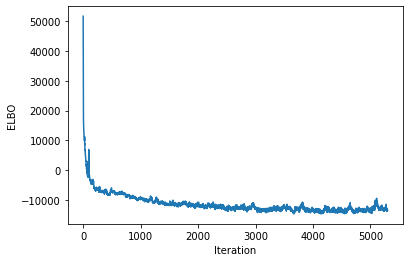

In [58]:
ELBO_plot = plot_elbo(ELBO_losses[10:], xmin=None, ymax=None)

In [64]:
x, _ = net(30)
print(x)

tensor([[[4.5546e+01, 1.4454e-02, 2.5204e-01],
         [4.5435e+01, 4.7092e-03, 4.2566e-01],
         [4.6297e+01, 2.2291e-02, 5.5511e-01],
         ...,
         [3.7925e+01, 2.6811e-01, 3.2380e-01],
         [3.7675e+01, 1.7853e-01, 2.0982e-01],
         [3.8305e+01, 1.5693e-01, 1.0868e+00]],

        [[4.3517e+01, 4.3595e-03, 2.1788e-01],
         [4.5950e+01, 1.4754e-04, 5.8599e-01],
         [4.6025e+01, 1.5155e-02, 5.1838e-01],
         ...,
         [3.7971e+01, 8.1096e-02, 7.6331e-01],
         [3.8099e+01, 8.4312e-02, 7.9059e-01],
         [3.8562e+01, 8.4983e-02, 1.6628e-01]],

        [[4.6327e+01, 3.4339e-04, 4.2047e-01],
         [4.5097e+01, 3.2379e-04, 3.6879e-01],
         [4.4419e+01, 1.2112e-01, 4.9814e-01],
         ...,
         [3.8910e+01, 1.1947e-01, 7.4311e-01],
         [3.8084e+01, 1.9124e-01, 1.2188e-01],
         [3.7856e+01, 3.0961e-01, 2.1163e-02]],

        ...,

        [[4.5298e+01, 2.3640e-04, 1.0430e-01],
         [4.5147e+01, 3.7275e-03, 3.7343e-01]

In [76]:
C0 = analytical_steady_state_init_CON(i_s_tensor[0, 0, 0].item(), i_d_tensor[0, 0, 0].item(), SCON_C_params_dict)

In [66]:
C0 = C0[(None,) * 2].repeat(30, 1, 1)
x = torch.cat((C0, x), 1)
x

tensor([[[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.5546e+01, 1.4454e-02, 2.5204e-01],
         [4.5435e+01, 4.7092e-03, 4.2566e-01],
         ...,
         [3.7925e+01, 2.6811e-01, 3.2380e-01],
         [3.7675e+01, 1.7853e-01, 2.0982e-01],
         [3.8305e+01, 1.5693e-01, 1.0868e+00]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.3517e+01, 4.3595e-03, 2.1788e-01],
         [4.5950e+01, 1.4754e-04, 5.8599e-01],
         ...,
         [3.7971e+01, 8.1096e-02, 7.6331e-01],
         [3.8099e+01, 8.4312e-02, 7.9059e-01],
         [3.8562e+01, 8.4983e-02, 1.6628e-01]],

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.6327e+01, 3.4339e-04, 4.2047e-01],
         [4.5097e+01, 3.2379e-04, 3.6879e-01],
         ...,
         [3.8910e+01, 1.1947e-01, 7.4311e-01],
         [3.8084e+01, 1.9124e-01, 1.2188e-01],
         [3.7856e+01, 3.0961e-01, 2.1163e-02]],

        ...,

        [[4.5660e+01, 7.1469e-02, 7.1469e-01],
         [4.5298e+01, 2.3640e-04, 1.0430e-01]

In [67]:
hours = torch.arange(0, t + dt, dt)

In [71]:
SOC_mean, SOC_std = x[:, :, 0].mean(0).detach(), x[:, :, 0].std(0).detach()
DOC_mean, DOC_std = x[:, :, 1].mean(0).detach(), x[:, :, 1].std(0).detach()
MBC_mean, MBC_std = x[:, :, 2].mean(0).detach(), x[:, :, 2].std(0).detach()

In [73]:
obs_times, obs_means, obs_error = old.csv_to_obs_df('CON_synthetic_sol_df.csv', 3 + 1, t, 0.25) 
obs_model = old.ObsModel(devi, obs_times, dt, obs_means[:-1, :], obs_error[:, :-1])

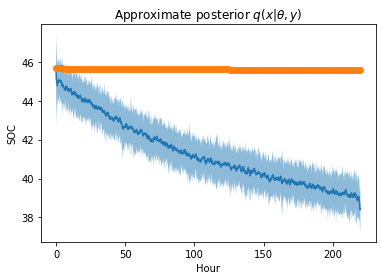

In [77]:
plot_post(net, C0, obs_model, 0, num_samples=50, ymin=None, ymax=None) #Plot SOC

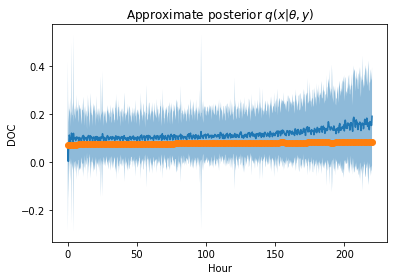

In [78]:
plot_post(net, C0, obs_model, 1, num_samples=50, ymin=None, ymax=None) #Plot DOC

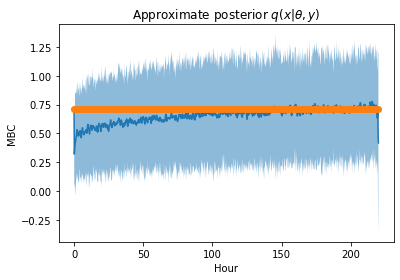

In [90]:
plot_post(net, C0, obs_model, 2, num_samples=50, ymin=None, ymax=None) #Plot MBC